# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. Leiden clusters are calculated for each object (latent, protein and RNA) and highly expressed genes/markers are searched using scanpy rank_genes_groups -function. Columns containing only zero-values were removed from RNA object. Mitochondrial and ribosomal genes are removed from analysis as well. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# 1. Preparations

In [2]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [3]:
adata = adata.copy()

In [4]:
#Both NK cell types selected  + one sample is selected

adata = adata[(adata.obs['cell_type'] == "NK") | (adata.obs['cell_type'] == "NK CD158e1+")]

In [5]:
#Selecting only one sample

adata =adata[adata.obs['POOL'] == "s1d2"]

In [6]:
adata.shape

(518, 21720)

In [7]:
#protein information saved

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [8]:
df = adata_prot

In [9]:
df=adata.obsm['protein_expression_clr_neurips'].astype(float)

In [10]:
#empty anndata file with correct shape (for protein data)

adata_new_prot = ad.AnnData(np.random.poisson(1, size=(518, 139)))

In [11]:
#adata file where X = CLR normalized protein 
adata_new_prot.X=df

In [12]:
#obs and var names identified

adata_new_prot.obs_names = df.index
adata_new_prot.var_names = df.columns

In [13]:
adata_new_prot

AnnData object with n_obs × n_vars = 518 × 139

In [14]:
#RNA expression to df

df_rna = adata.to_df()

In [15]:
#selecting nonzero columns (at least some expression detected), these are removed next

nonzero = df_rna.columns[(~(df_rna == 0)).sum() != 0]

In [16]:
#RNA data (zero columns removed) is added to obs 

df_rna=adata.to_df().loc[:,nonzero]

In [17]:
df_rna.shape

(518, 13375)

In [18]:
#empty anndata file with correct shape (for RNA data)

adata_new_rna = ad.AnnData(np.random.poisson(1, size=(518, 13375)))

In [19]:
#adata file where X = RNA expression

adata_new_rna.X=df_rna

In [20]:
#obs and var names identified

adata_new_rna.obs_names = df_rna.index
adata_new_rna.var_names = df_rna.columns

In [21]:
adata_new_rna

AnnData object with n_obs × n_vars = 518 × 13375

In [22]:
import muon as mu

In [23]:
#Combine previous two adata files into one muon object

mdata = mu.MuData({'rna': adata_new_rna, 'adt': adata_new_prot})

In [24]:
mdata.obsm

MuAxisArrays with keys: rna, adt

In [25]:
#anndata file containing only RNA expression
adata_gex = mdata.mod['rna'].copy()

In [26]:
#anndata file containing only CLR normalized protein counts

adata_adt = mdata.mod['adt'].copy()

In [27]:
#Neurips, latent

adata_latent = adata.copy()

# 2. Leiden clusters

In [28]:
#PCA for RNA and protein

sc.pp.pca(adata_gex)
sc.pp.pca(adata_adt)

In [29]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")   
sc.pp.neighbors(adata_adt) 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

In [30]:
#Calculating leidens for latent object
sc.tl.leiden(adata_latent, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_latent, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_latent, resolution = 0.6, key_added = "leiden_0.6")

#calculating leidens for protein object
sc.tl.leiden(adata_adt, resolution = 0.2, key_added = "leiden_0.2")
sc.tl.leiden(adata_adt, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_adt, resolution = 0.6, key_added = "leiden_0.6")

#calculating leidens for RNA object
sc.tl.leiden(adata_gex, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata_gex, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata_gex, resolution = 0.8, key_added = "leiden_0.8")
sc.tl.leiden(adata_gex, resolution = 0.95, key_added = "leiden_0.95")




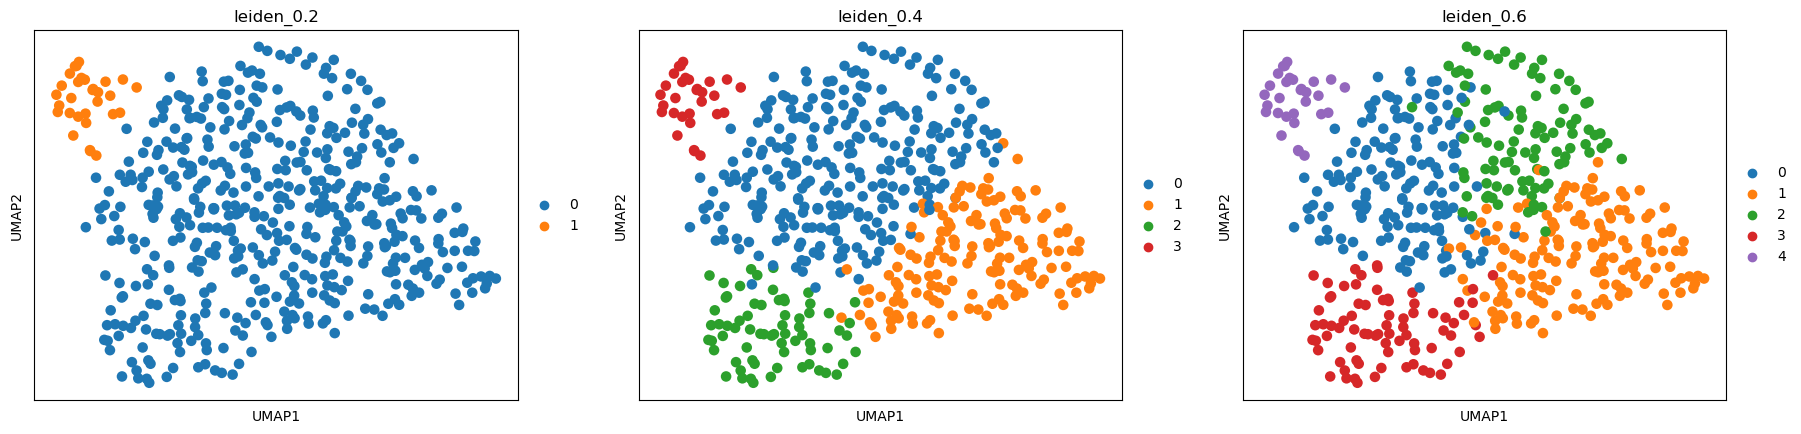

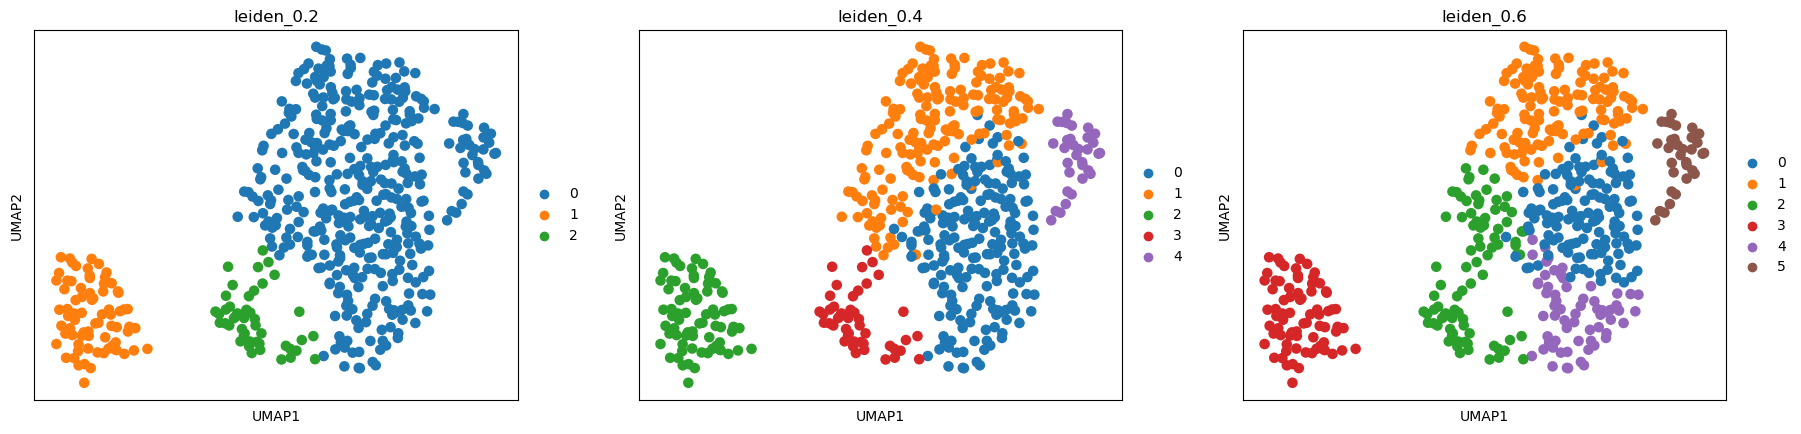

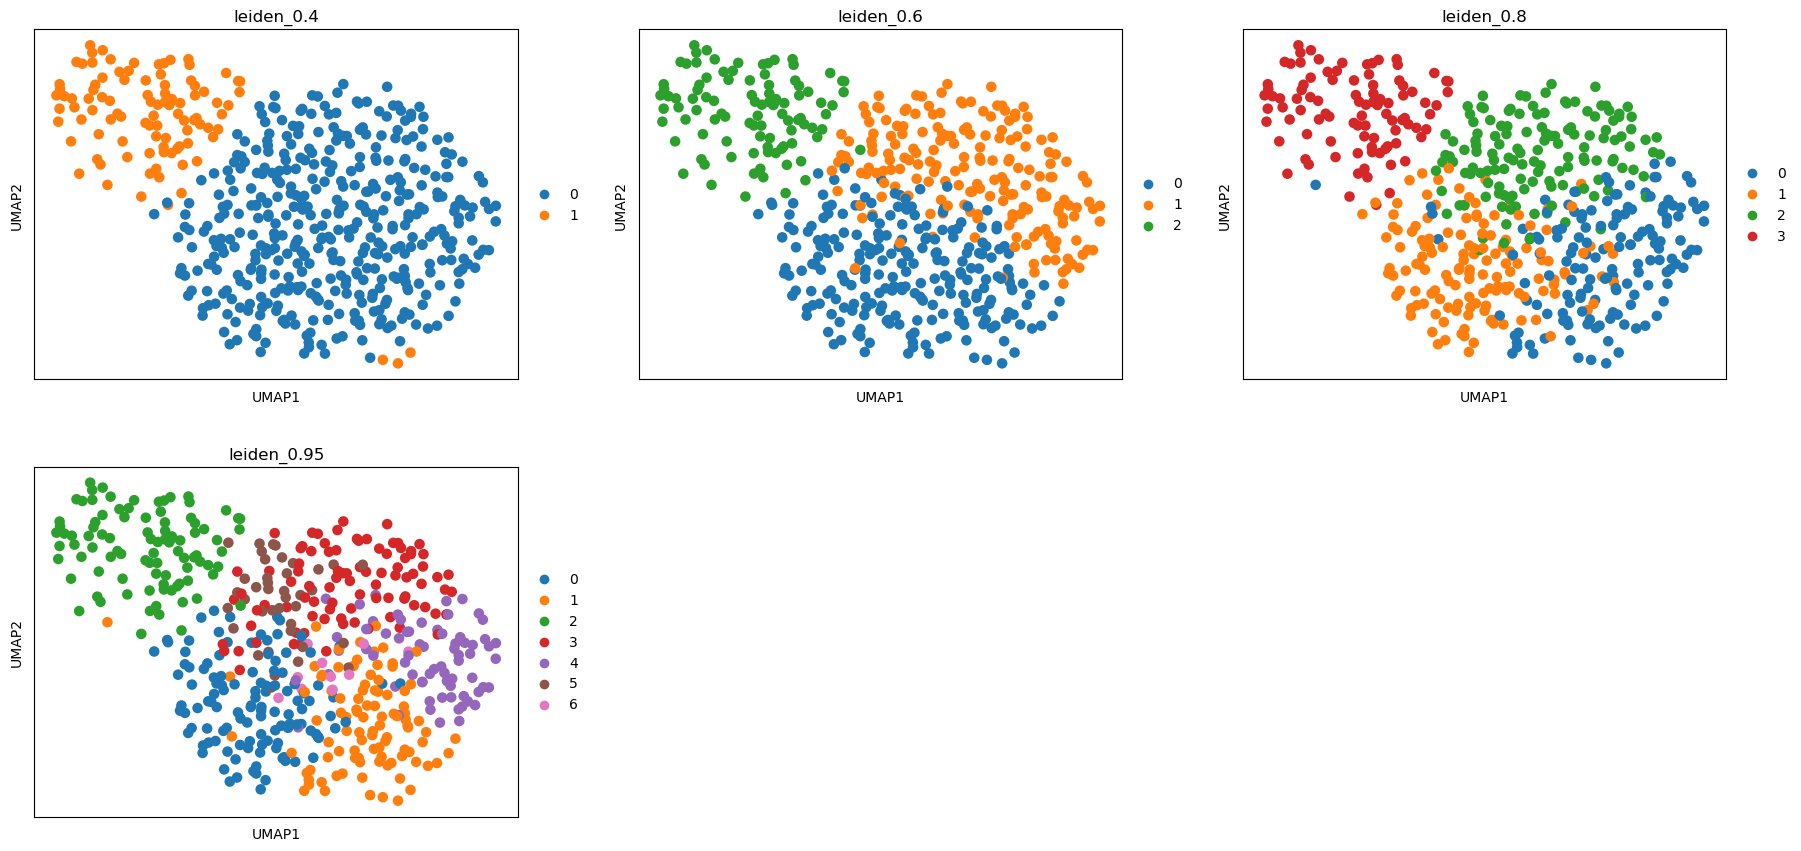

In [31]:
#Showing results in UMAPs


sc.pl.umap(adata_latent, color=['leiden_0.2', 'leiden_0.4', 'leiden_0.6'], ncols =3)
sc.pl.umap(adata_adt, color=['leiden_0.2', 'leiden_0.4', 'leiden_0.6'], ncols =3)
sc.pl.umap(adata_gex, color=['leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_0.95'], ncols =3)

# 2.1  Find marker genes/proteins from leiden clusters, latent

In [32]:
#Removing mito + ribo genes from adata_gex

#genes to be removed
mito_genes = adata_gex.var_names.str.startswith('MT-')
ribo_genes = adata_gex.var_names.str.startswith('RPL')
ribo_genes1 = adata_gex.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_gex = adata_gex[:,keep]

print(adata_gex.n_obs, adata_gex.n_vars)

518 13268


In [33]:
#Removing mito + ribo genes from adata_latent

#genes to be removed
mito_genes = adata_latent.var_names.str.startswith('MT-')
ribo_genes = adata_latent.var_names.str.startswith('RPL')
ribo_genes1 = adata_latent.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_latent = adata_latent[:,keep]

print(adata_latent.n_obs, adata_latent.n_vars)

518 21604


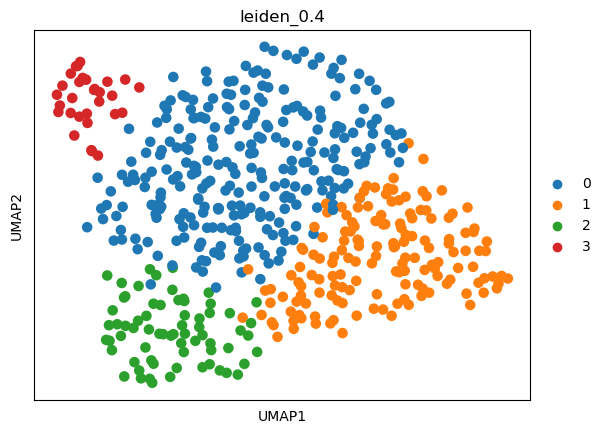

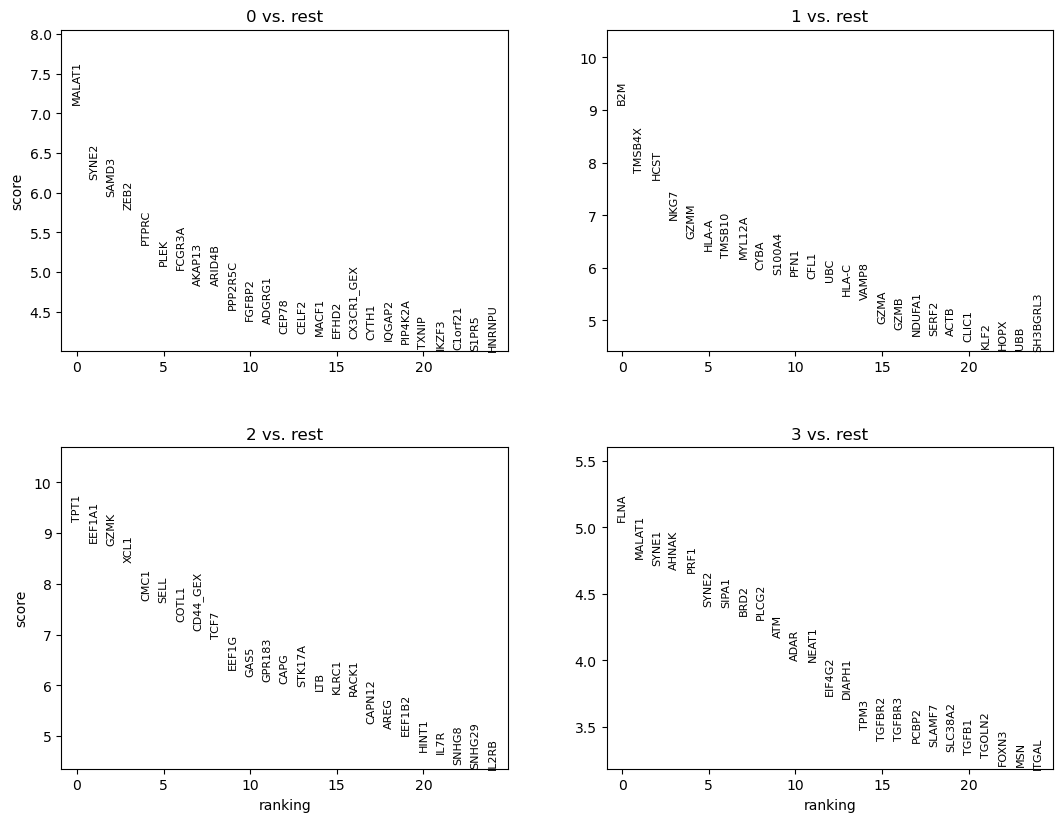

In [34]:
#Latent

sc.pl.umap(adata_latent, color=['leiden_0.4'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0.4', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

- Cluster 0: SYNE2, ZEB2 FCGR3A (CD16) => mature, terminal?
- Cluster 1: B2M, NKG7, granzymes M, A, B) => mature CD56dim NK (Huuhtanen, Yang). 
- Corresponds cluster 0 in s4d1.
- Cluster 2: granzyme K, XCL1, SELL => Immature CD56bright
- Cluster 4: SYNE1, AHNAK, PRF1, PLCG2

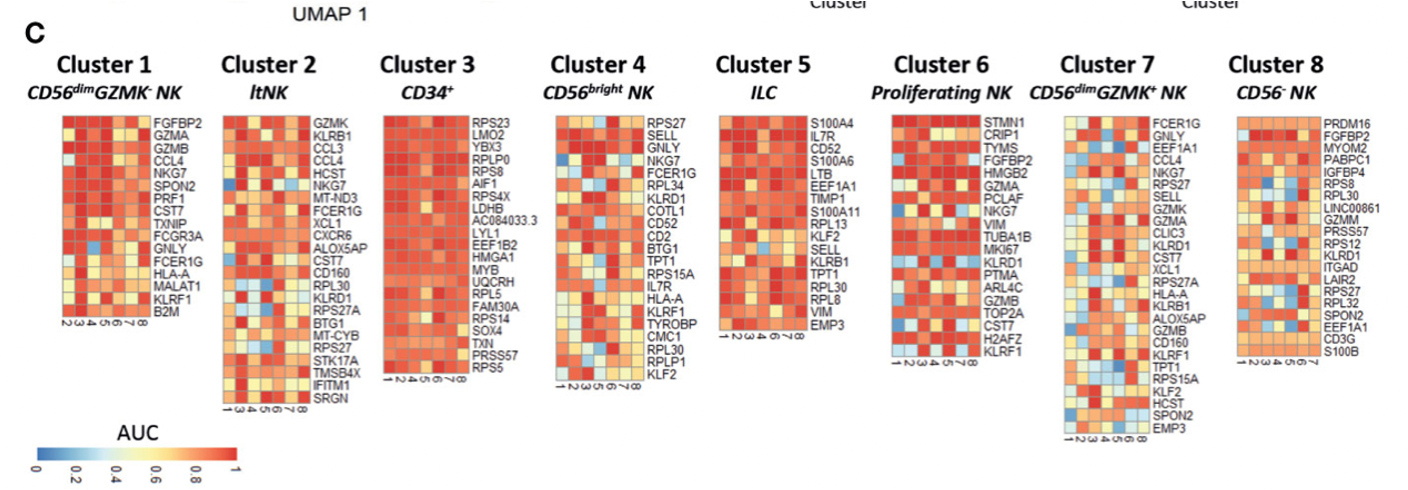
(Melsen et al. 2022)


- Clusters 1, 2, 4, 6, 7 of above figure were found also in other datasets (Crinier + Yang) 

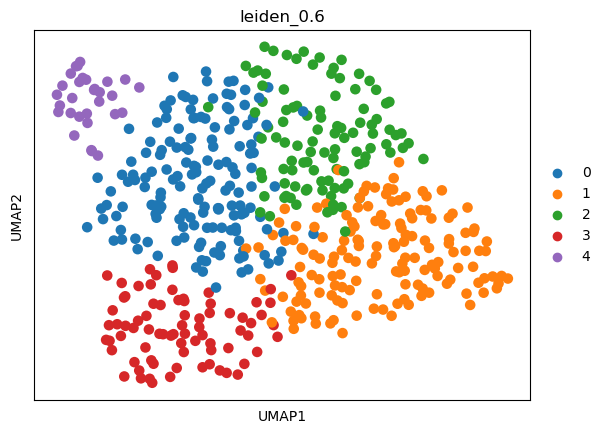

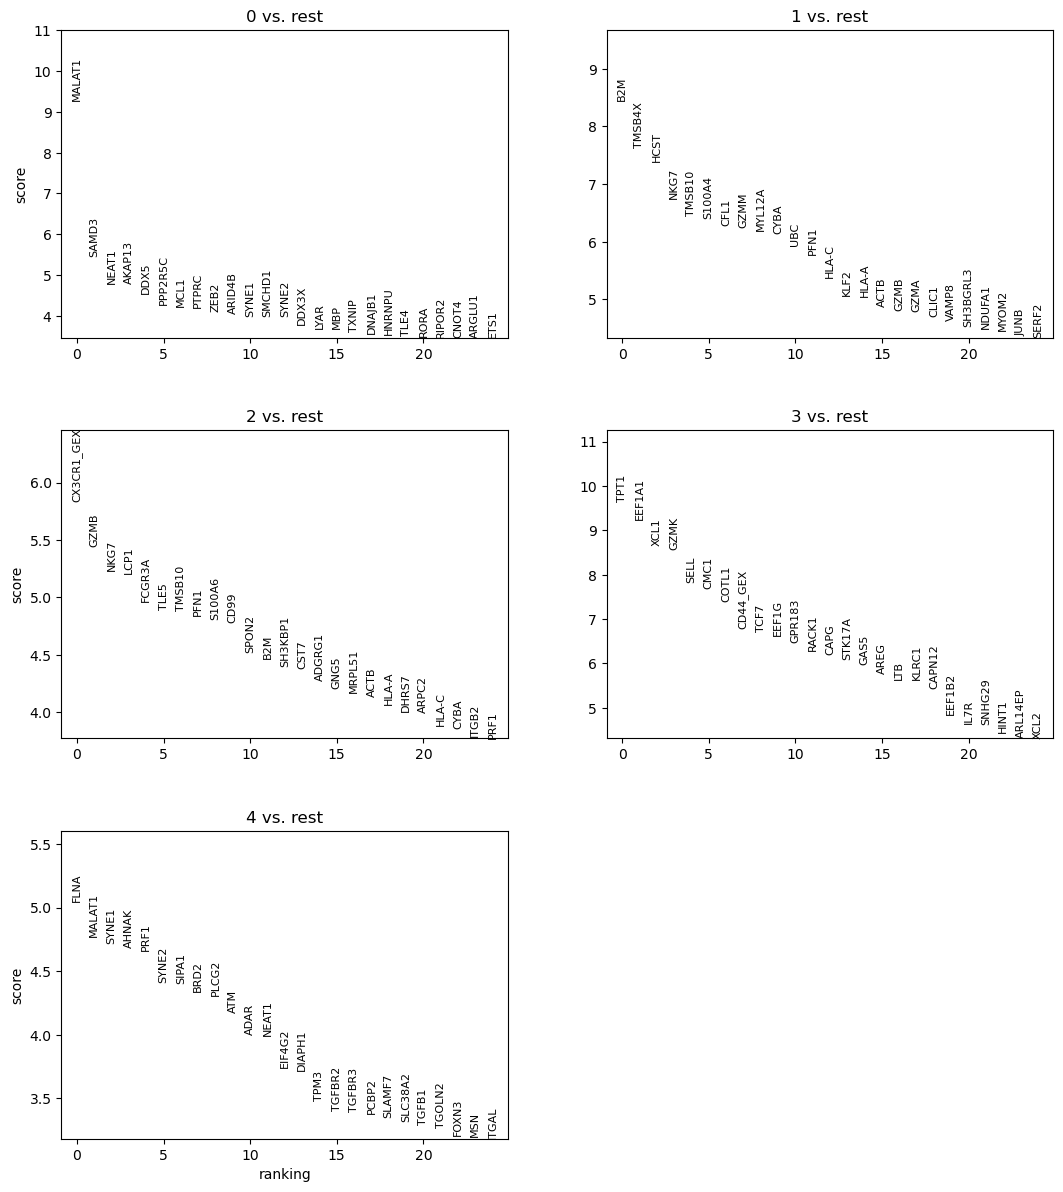

In [35]:
#Latent

sc.pl.umap(adata_latent, color=['leiden_0.6'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0.6', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

In [55]:
adata_latent.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [63]:
pd.DataFrame(adata_latent.uns['rank_genes_groups']['names'])

0       1           2     3,0       3,1       4
0       MALAT1     B2M  CX3CR1_GEX    TPT1    EEF1A1    FLNA
1        SAMD3  TMSB4X        GZMB    XCL1  CD44_GEX  MALAT1
2        NEAT1    HCST        NKG7  EEF1A1      SELL   SYNE1
3       AKAP13    NKG7        LCP1    GZMK      TPT1   AHNAK
4         DDX5  TMSB10      FCGR3A    CMC1      GZMK    PRF1
...        ...     ...         ...     ...       ...     ...
21599  PRELID1   DDX17        IER2  FCGR3A      PRF1     FTL
21600     CTSW    NKTR         FOS    PRF1    FGFBP2  MYL12A
21601     PFN1  HNRNPU        JUNB   MYOM2     SPON2     FAU
21602     ACTB   PTPRC        BTG1    GZMB    FCGR3A     B2M
21603   TMSB10  MALAT1         JUN  FGFBP2      GZMB  TMSB4X

[21604 rows x 6 columns]

- Cluster 3: SELL, GZMK, XCL1 => Immature CD56bright
- Proliferating NK? STM1, TYMS, HMGB2, H2FZ (Melsen) => not found? 
- Cluster 0 or 5 corresponds cluster 0 in s4d1
- Cluster 2 corresponding cluster 1 in Melsen paper ? => Mature CD56dim, terminal?
- Clusters 0,1,2 and 4 mature NK cells?
- Cluster 4 corrersponds cluster 0 in s4d1?

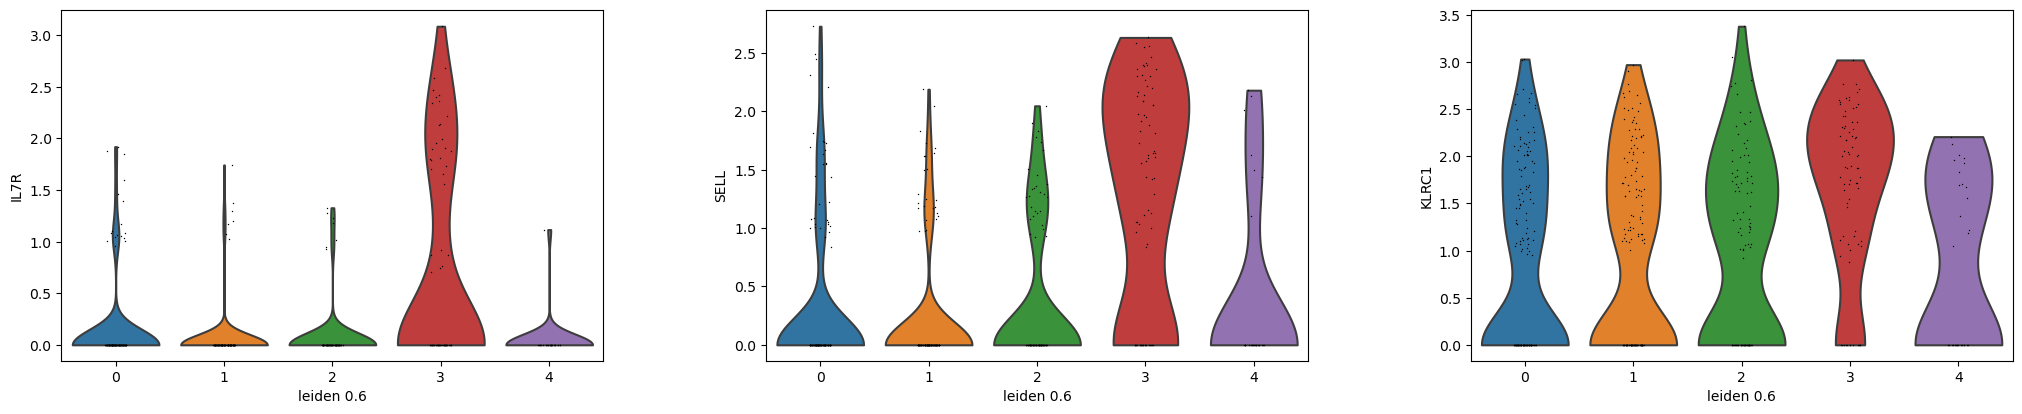

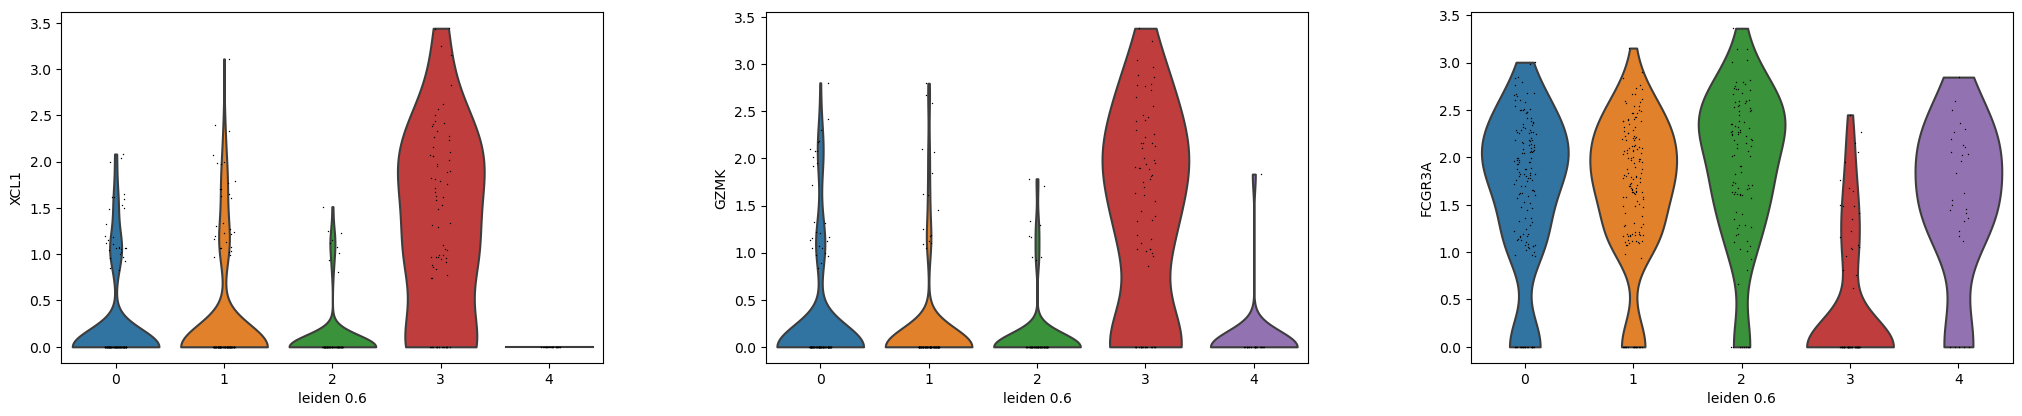

In [36]:
#Expression of genes known to be highly expressed in CD56bright NK cells (Melsen, Yang)

sc.pl.violin(adata_latent, ['IL7R', 'SELL', 'KLRC1'], groupby='leiden_0.6')

sc.pl.violin(adata_latent, ['XCL1', 'GZMK', 'FCGR3A'], groupby='leiden_0.6')

- These violinplots support the previous conclusion that cluster 4 corresbonds to immature CD56bright NK cells. Propably two bit different cell populations within cluster 3? => subclustering of this cluster

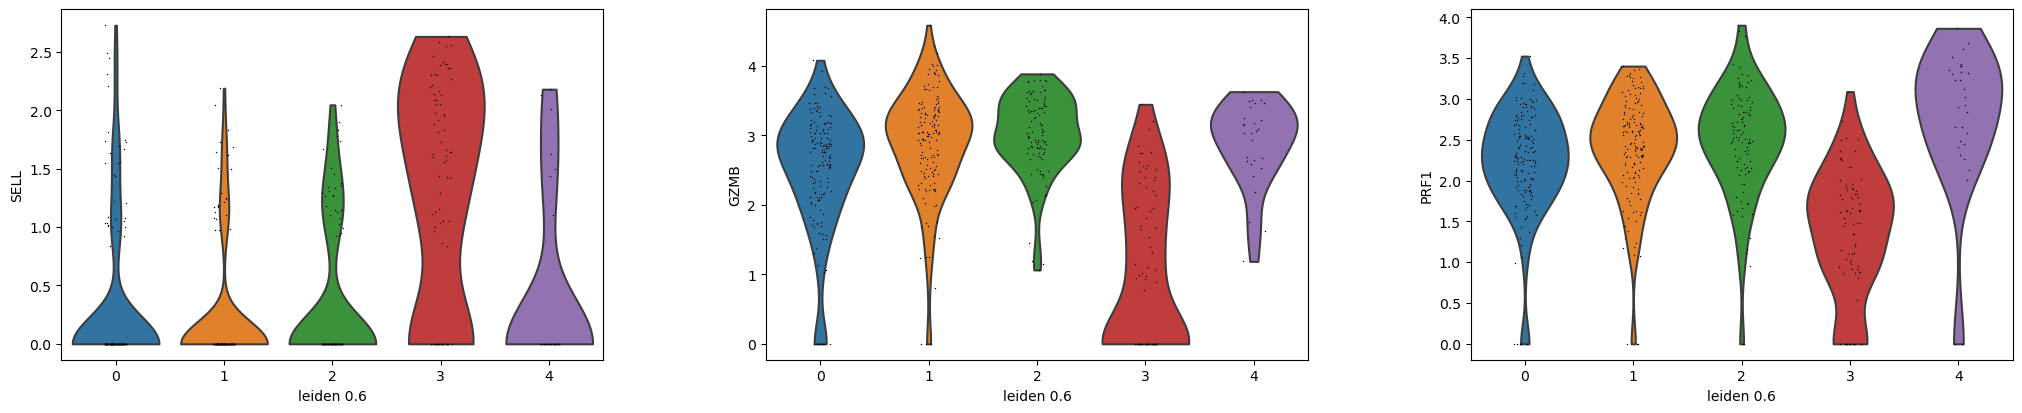

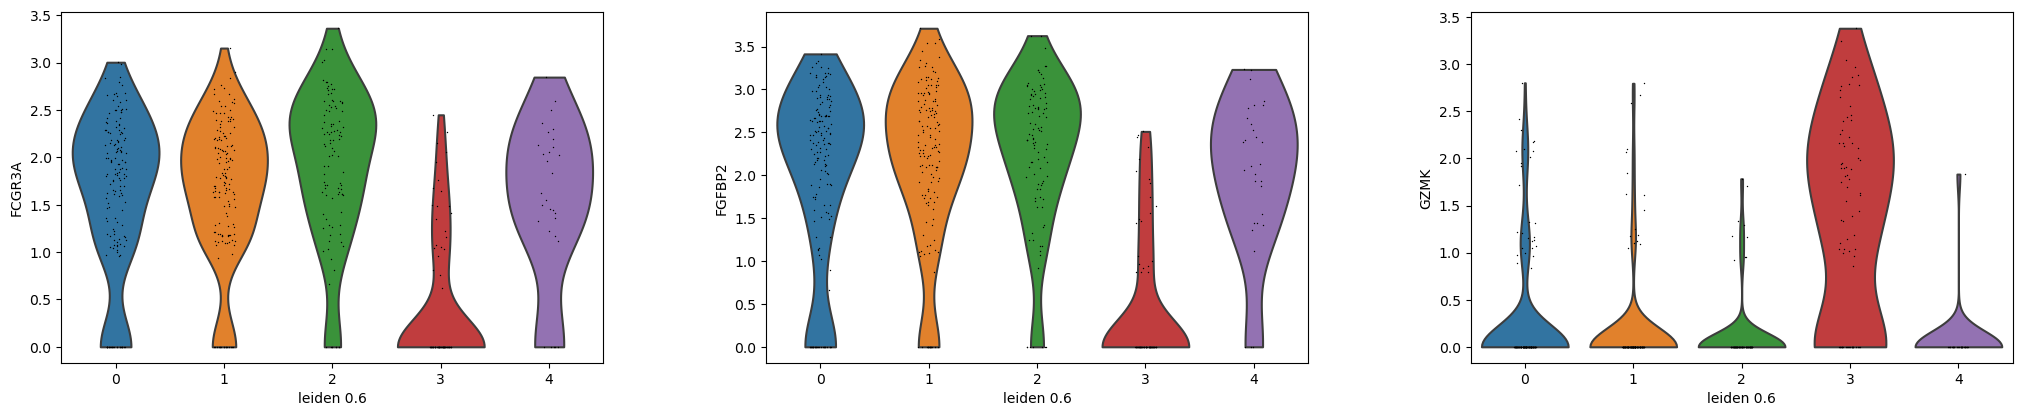

In [37]:
#CD65dim GZMK+ NK markers, transitional state between mature and immature (Melsen)

sc.pl.violin(adata_latent, ['SELL', 'GZMB', 'PRF1'], groupby='leiden_0.6')

sc.pl.violin(adata_latent, ['FCGR3A', 'FGFBP2', 'GZMK'], groupby='leiden_0.6')

According to Melsen at al. ;  "The CD56dimGZMK+ NK cells were further characterized by higher expression of SELL (CD62L), and lower expression of GZMB, PRF1 and FCGR3A (CD16) and FGFBP2 compared to CD56dimGZMK- cells"

- Here differences between clusters 0-3, which represent mature NK cells, are difficult to see. GZMB highest and GZMK lowest in cluster 3 => the most mature NKs? 

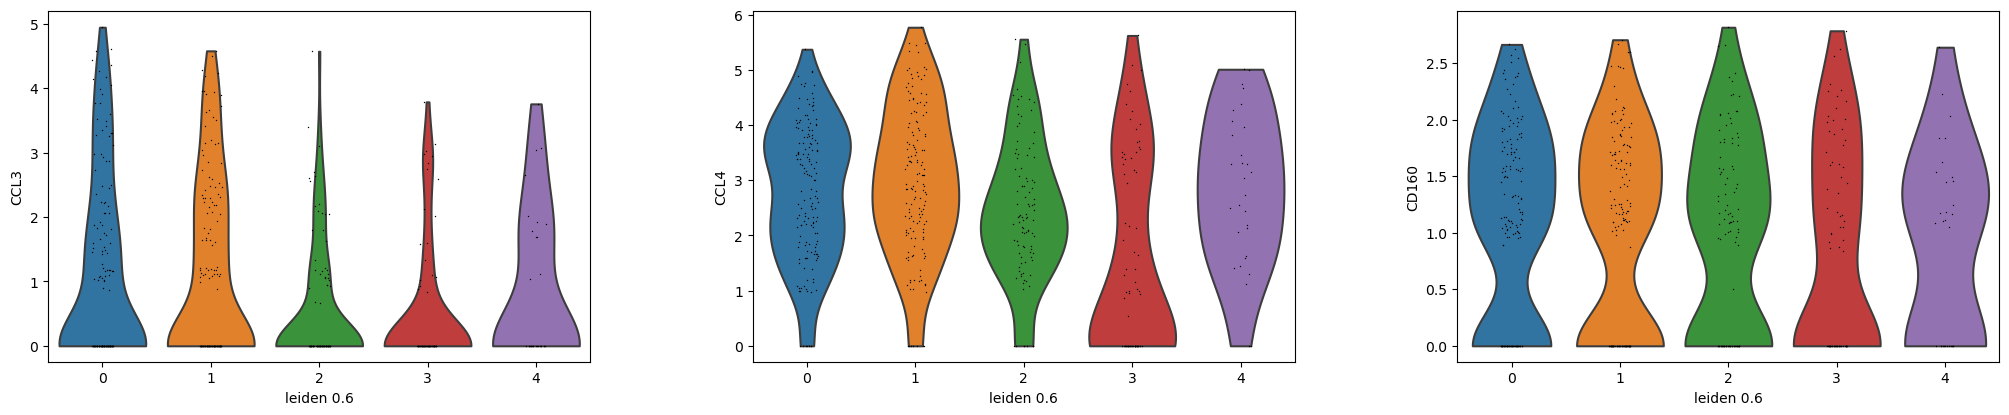

In [38]:
#Expression of genes known to be highly expressed in tissue resident ltNK (Melsen)

sc.pl.violin(adata_latent, ['CCL3', 'CCL4', 'CD160'], groupby='leiden_0.6')



- No clear ltNK corresponding cluster detected.

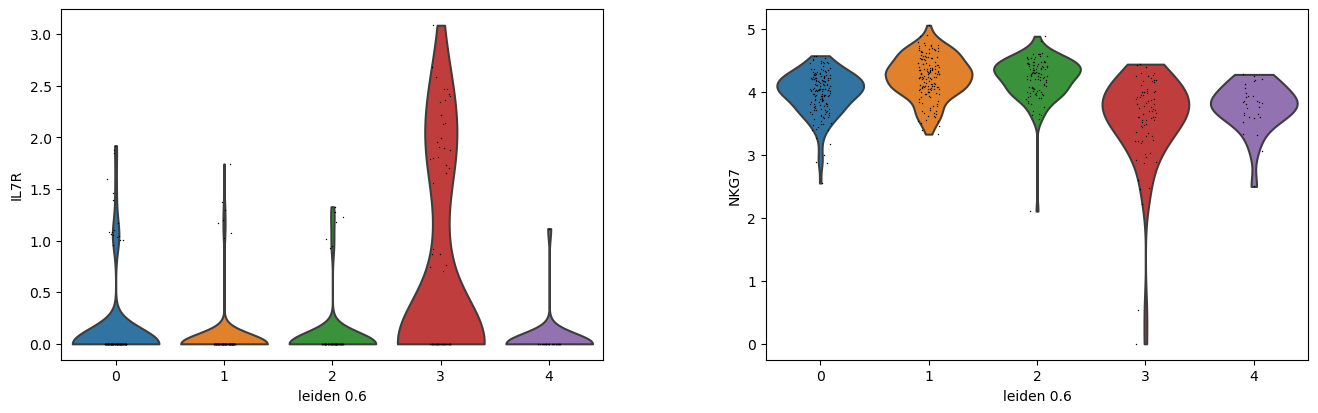

In [39]:
#ILC, high IL7R and absence of NKG7

sc.pl.violin(adata_latent, ['IL7R', 'NKG7'], groupby='leiden_0.6')


- ILCs could be sub-population of cluster 4 (immature cD56bright)? Small number of cells seems to have high IL7R expression and low NKG7 expression? 

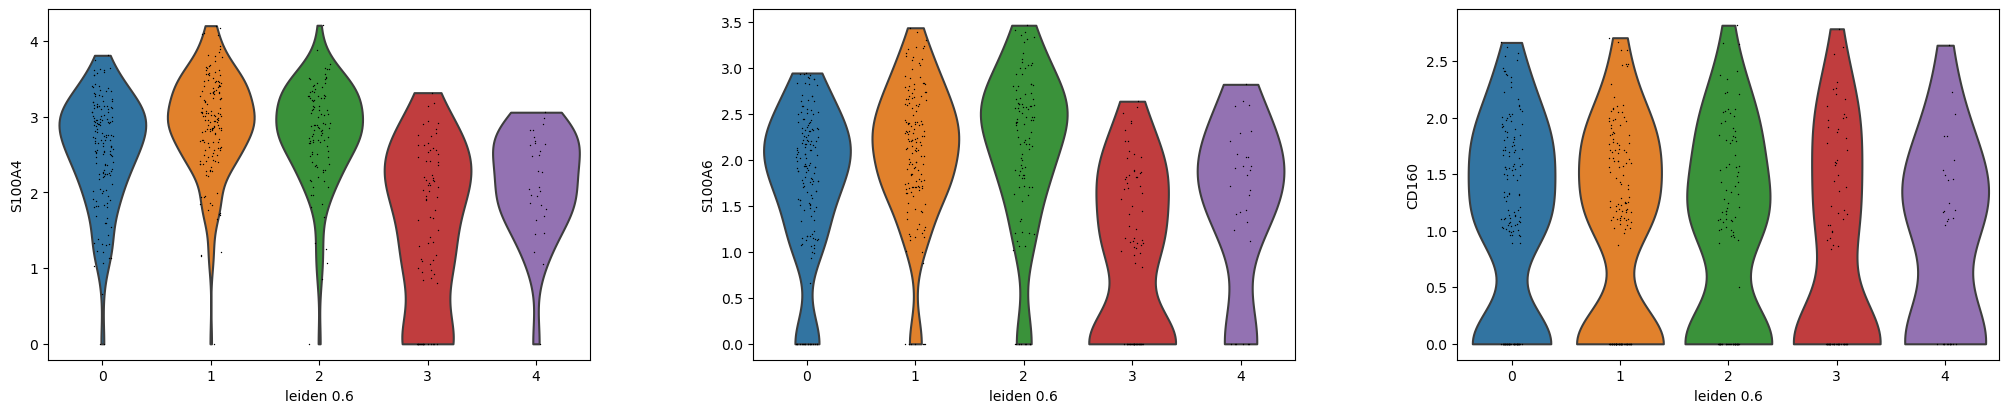

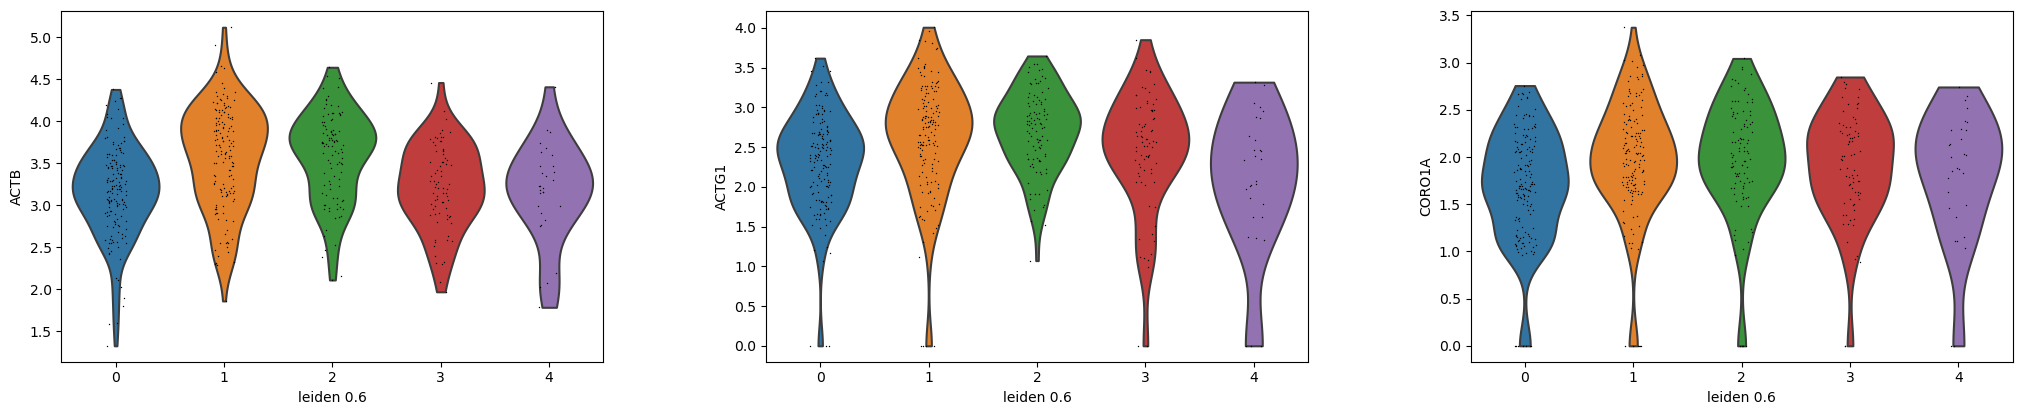

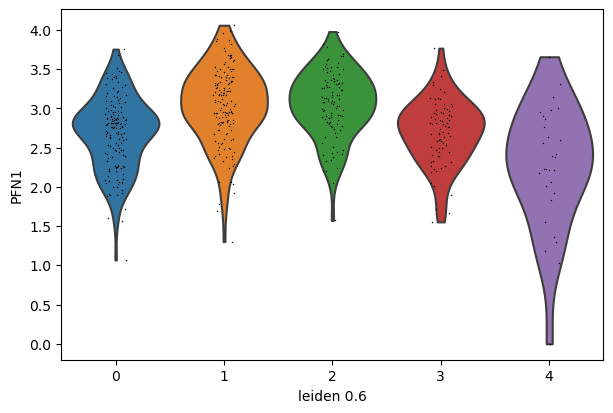

In [40]:
#Within CD56dim GZMK- clusters subclusters? (Melsen)

#Terminally differentiated NK
sc.pl.violin(adata_latent, ['S100A4', 'S100A6', 'CD160'], groupby='leiden_0.6')

#Cytoskeleton markers  => CD57+ high cytotoxicity 
sc.pl.violin(adata_latent, ['ACTB', 'ACTG1', 'CORO1A'], groupby='leiden_0.6') 
sc.pl.violin(adata_latent, ['PFN1'], groupby='leiden_0.6')


Up-reg


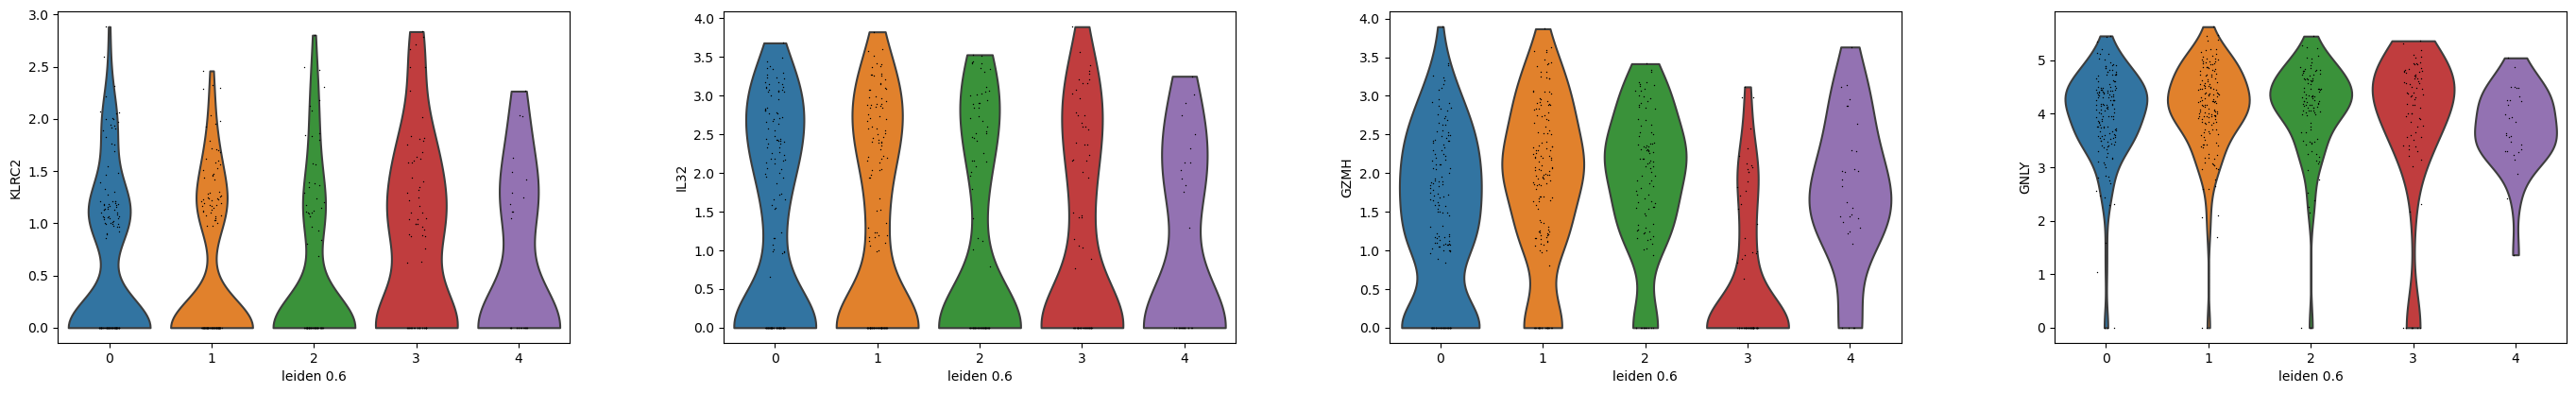

Down-reg


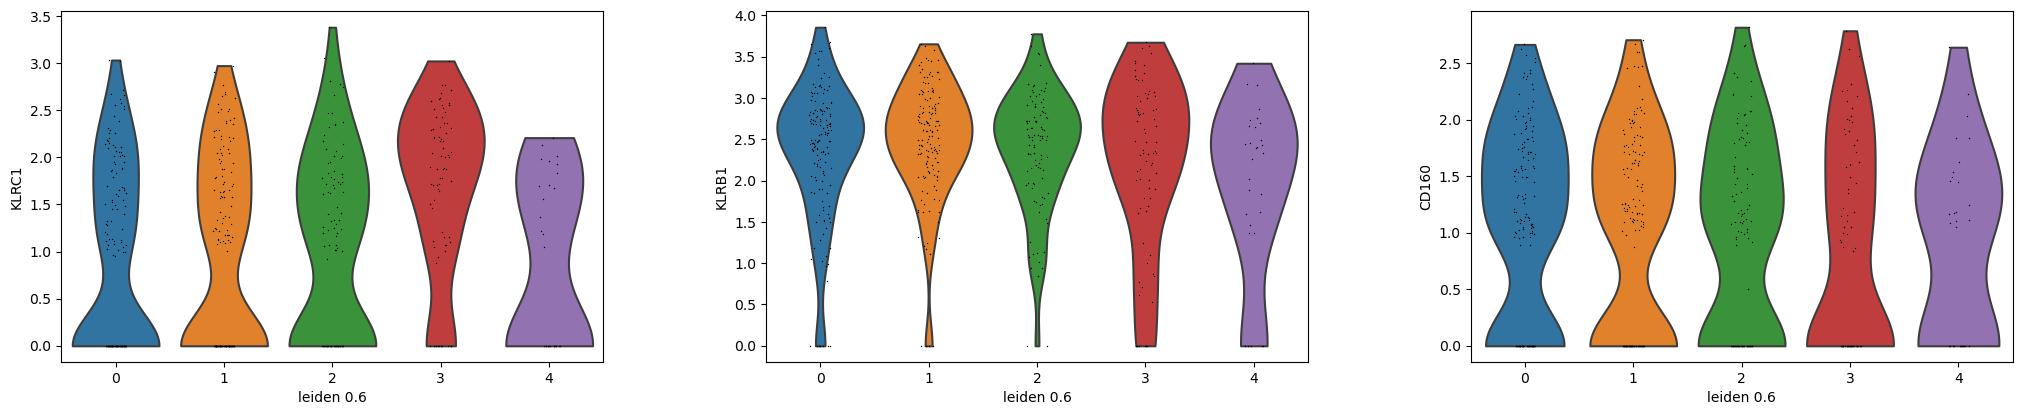

Up-reg


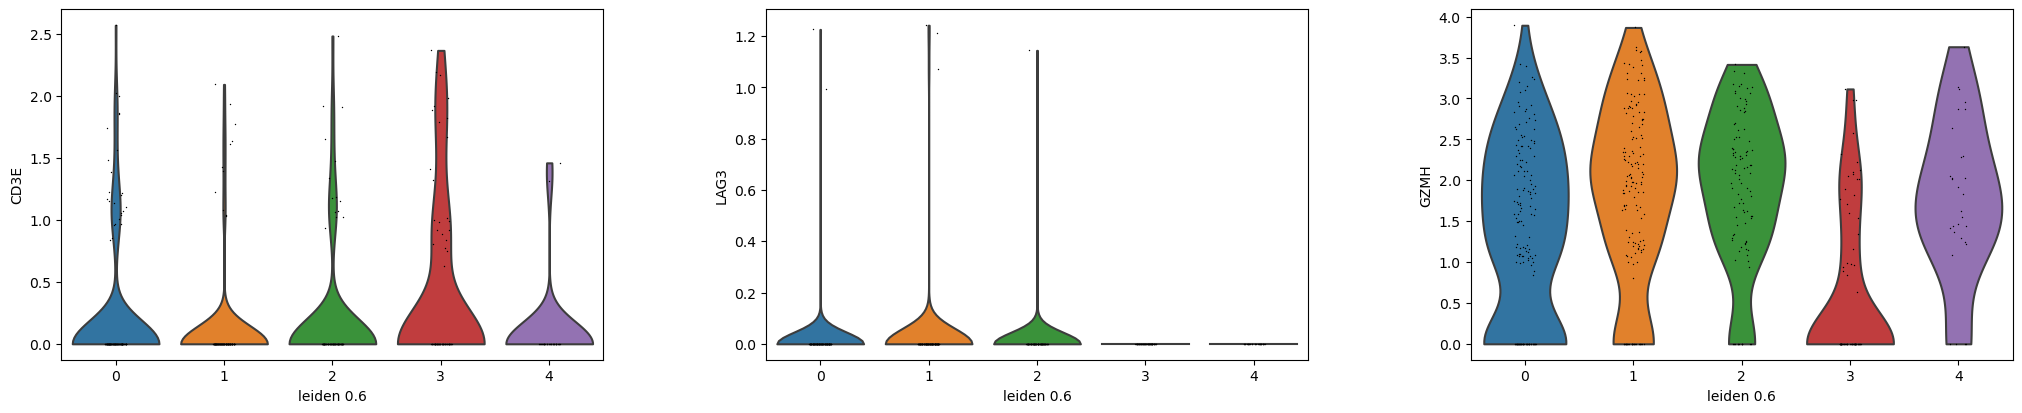

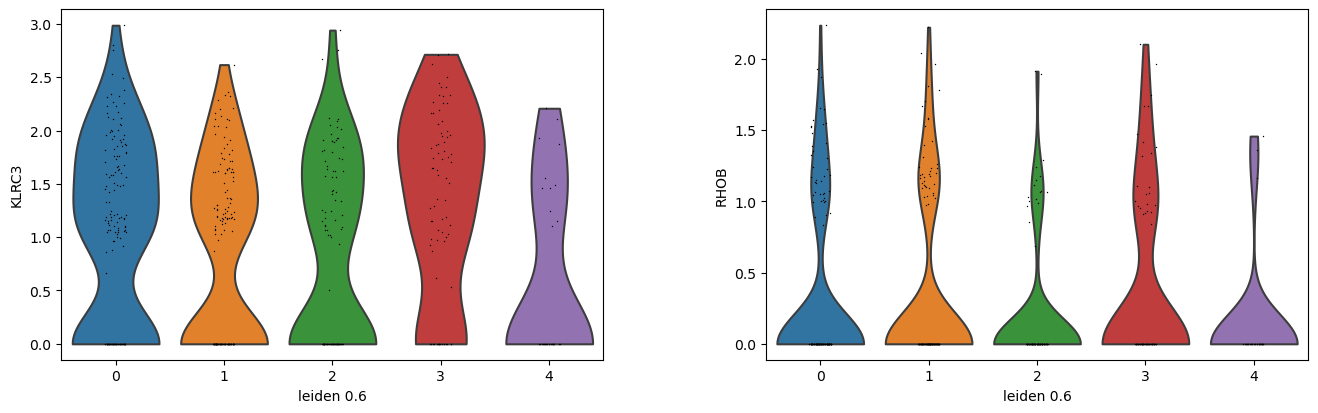

In [41]:
#Adaptive-like, up regulated (Melsen)

print('Up-reg')
sc.pl.violin(adata_latent, ['KLRC2', 'IL32', 'GZMH', 'GNLY'], groupby='leiden_0.6') 

print('Down-reg')
#Adaptive-like, down regulated (Melsen)
sc.pl.violin(adata_latent, ['KLRC1', 'KLRB1', 'CD160'], groupby='leiden_0.6') 

print('Up-reg')
#Adaptive like, up regulated (Huuhtanen et al)
sc.pl.violin(adata_latent, ['CD3E', 'LAG3', 'GZMH'], groupby='leiden_0.6') 
sc.pl.violin(adata_latent, ['KLRC3', 'RHOB'], groupby='leiden_0.6')

## Subclustering

In [42]:
orig_key = 'leiden_0.6' 
new_key = 'leiden_0.6'
new_rg_key = 'rg_res0.6_sub'
sub_key = '3'

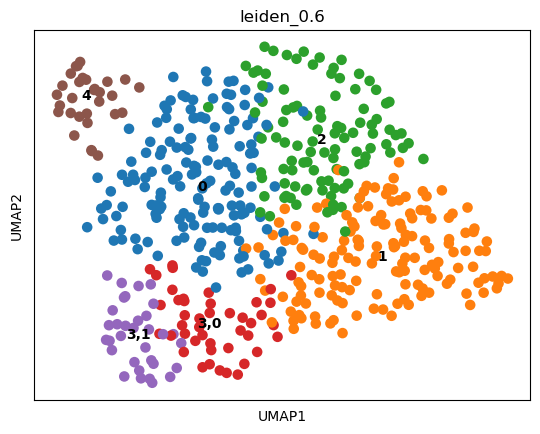

0      157
1      152
2      102
3,0     44
3,1     33
4       30
Name: leiden_0.6, dtype: int64

In [43]:
res = 0.5
sc.tl.leiden(adata_latent, restrict_to=(orig_key, [sub_key]), key_added=new_key, resolution=res)
sc.pl.umap(adata_latent, color=new_key, legend_loc = 'on data')
adata_latent.obs[new_key].value_counts()

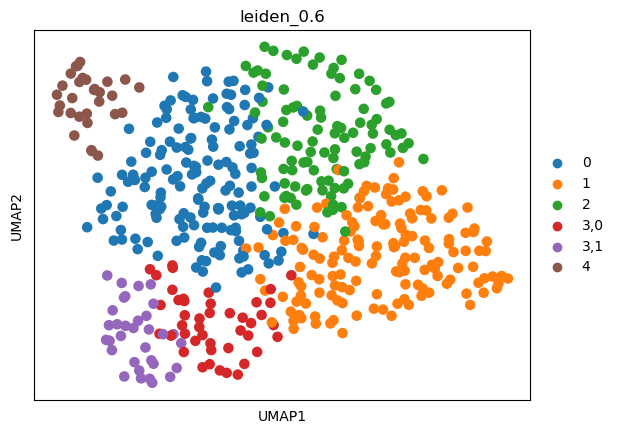

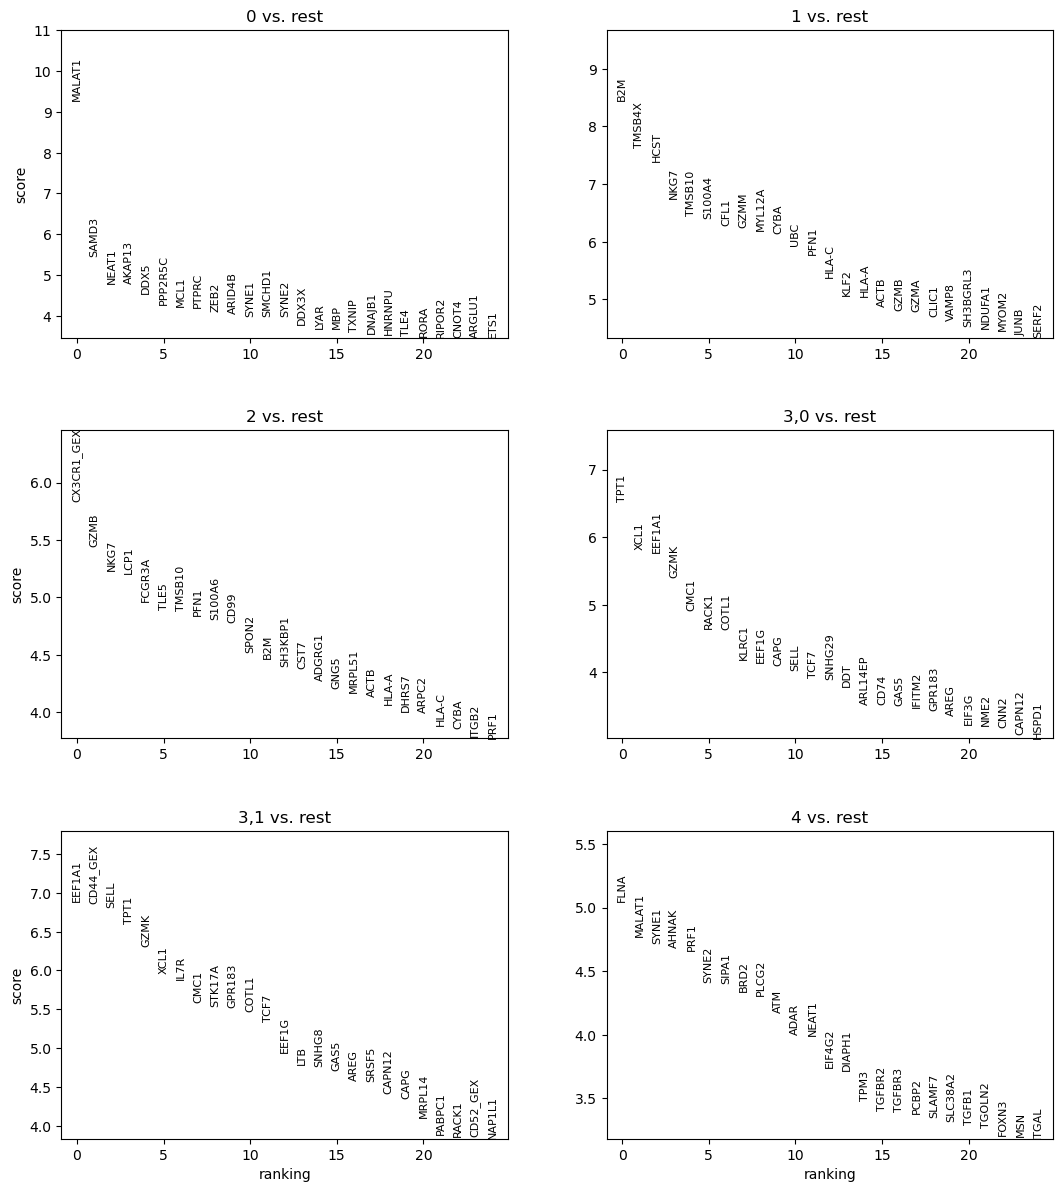

In [44]:
#Latent, again after subclustering of cluster 3

sc.pl.umap(adata_latent, color=['leiden_0.6'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0.6', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

### Melsen markers

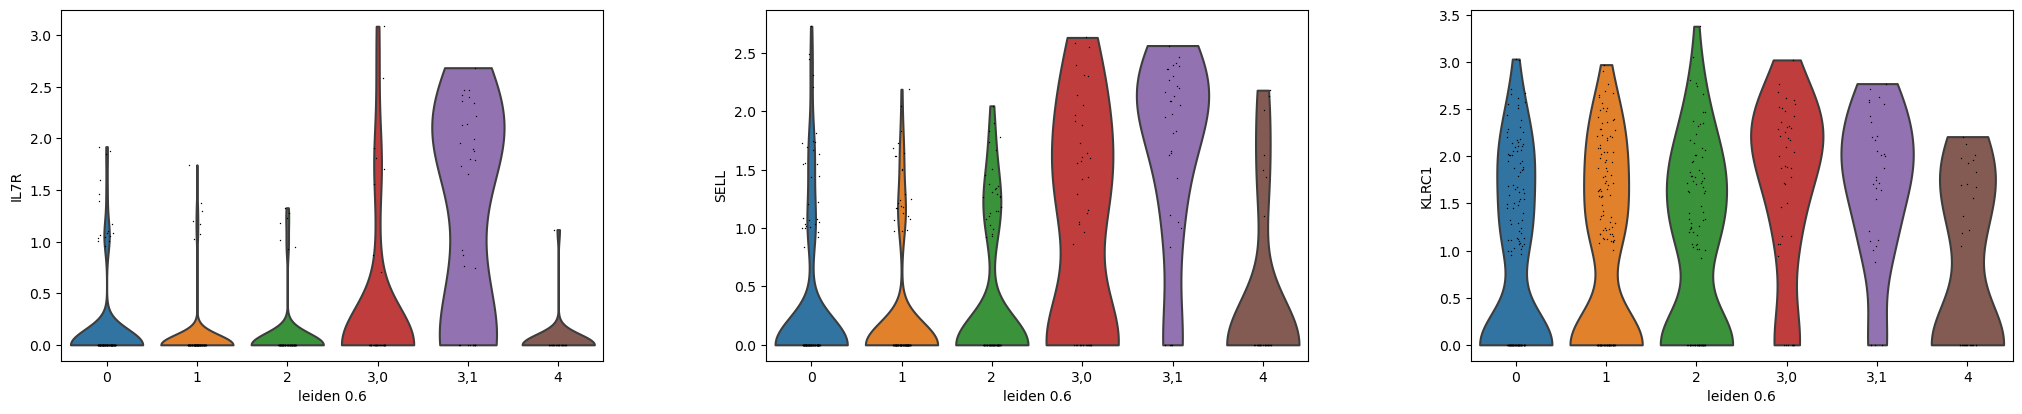

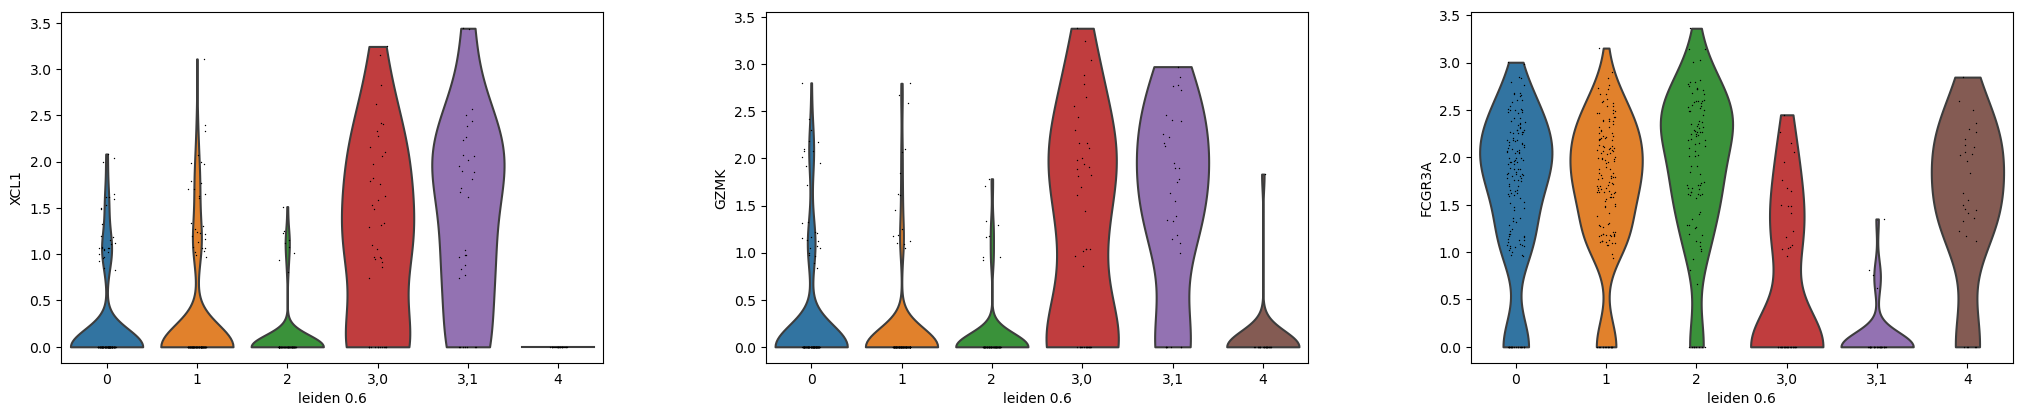

In [45]:
#Expression of genes known to be highly expressed in CD56bright NK cells (Melsen)

sc.pl.violin(adata_latent, ['IL7R', 'SELL', 'KLRC1'], groupby='leiden_0.6')

sc.pl.violin(adata_latent, ['XCL1', 'GZMK', 'FCGR3A'], groupby='leiden_0.6')

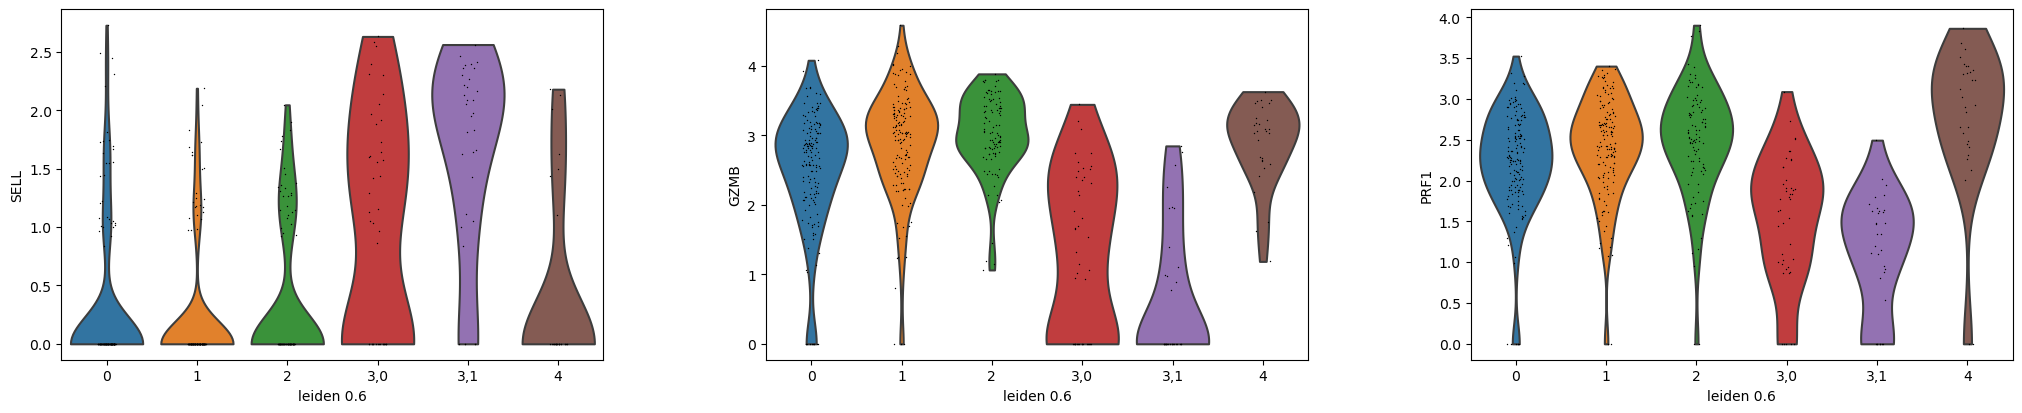

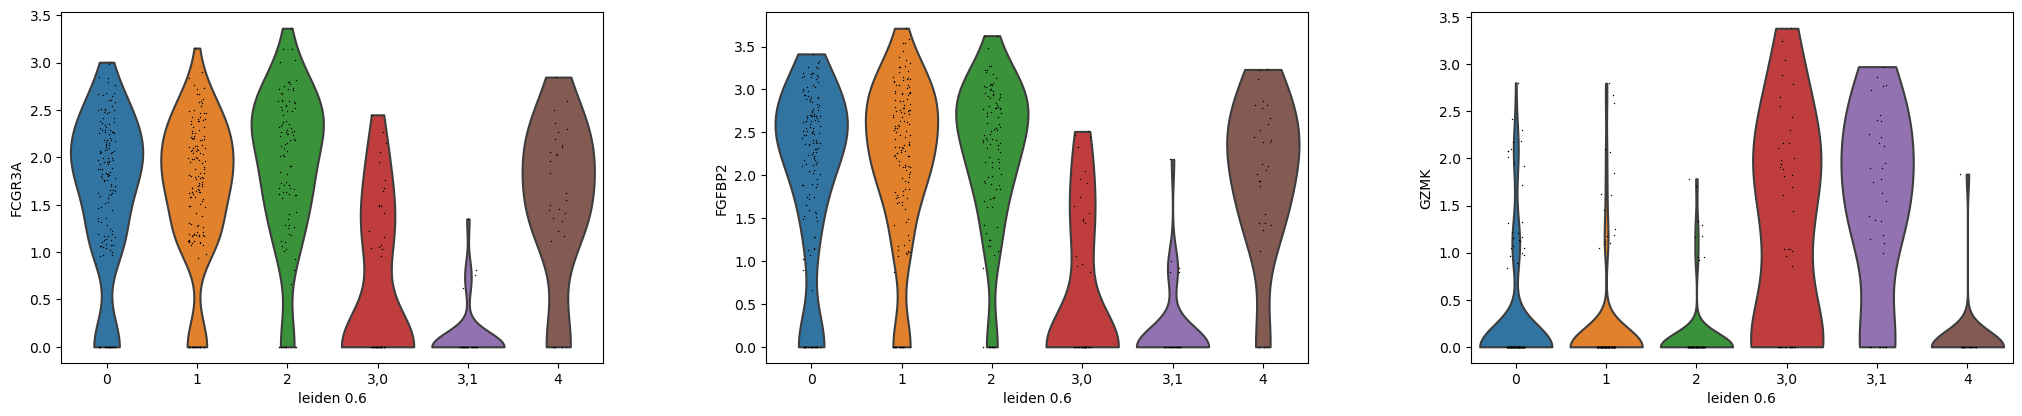

In [46]:
#CD65dim GZMK+ NK markers, transitional state between mature and immature (Melsen)

sc.pl.violin(adata_latent, ['SELL', 'GZMB', 'PRF1'], groupby='leiden_0.6')

sc.pl.violin(adata_latent, ['FCGR3A', 'FGFBP2', 'GZMK'], groupby='leiden_0.6')

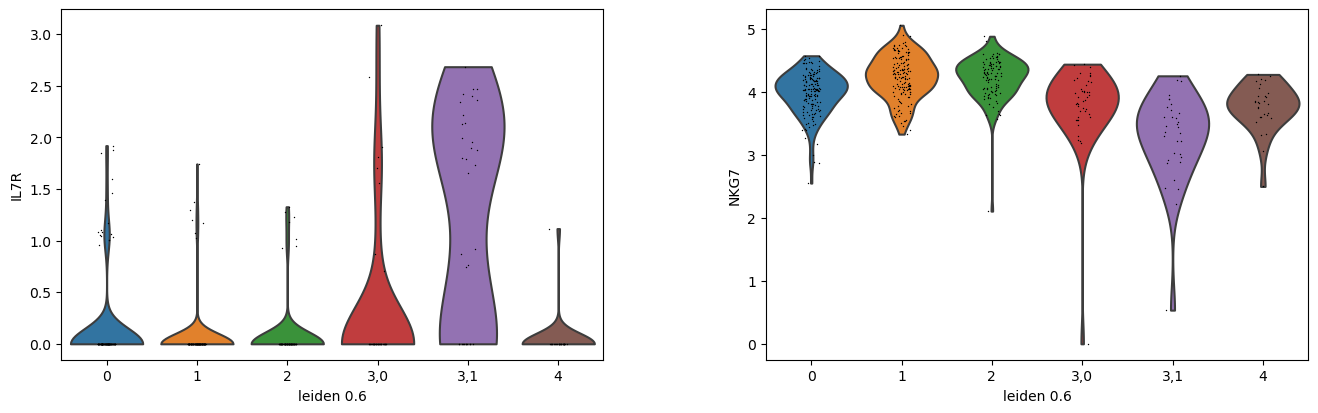

In [47]:
#ILC, high IL7R and absence of NKG7

sc.pl.violin(adata_latent, ['IL7R', 'NKG7'], groupby='leiden_0.6')

### Yang markers

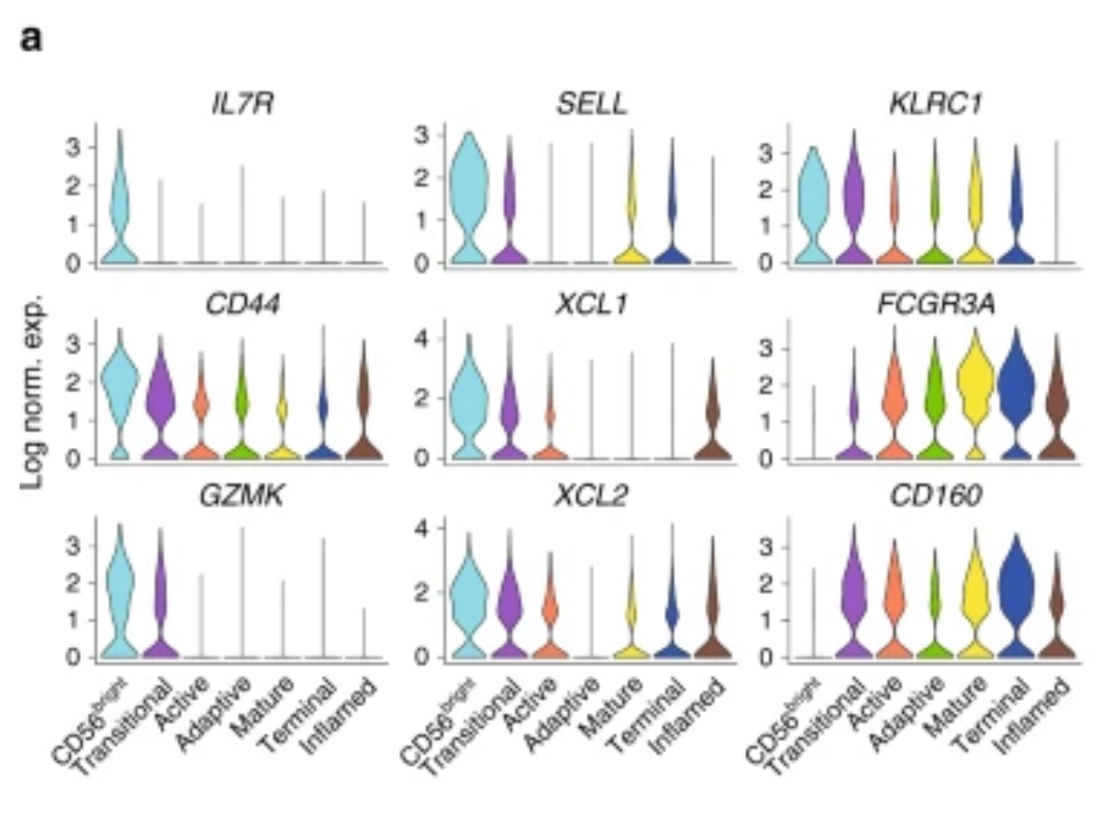

Yang et al. 

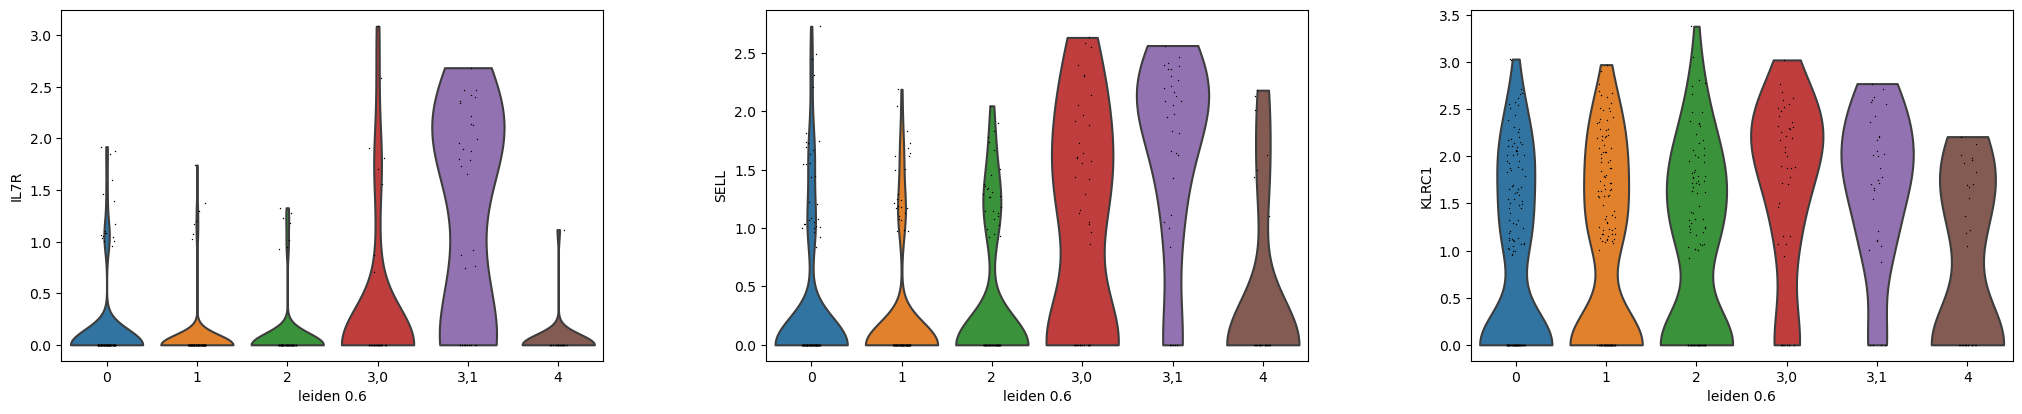

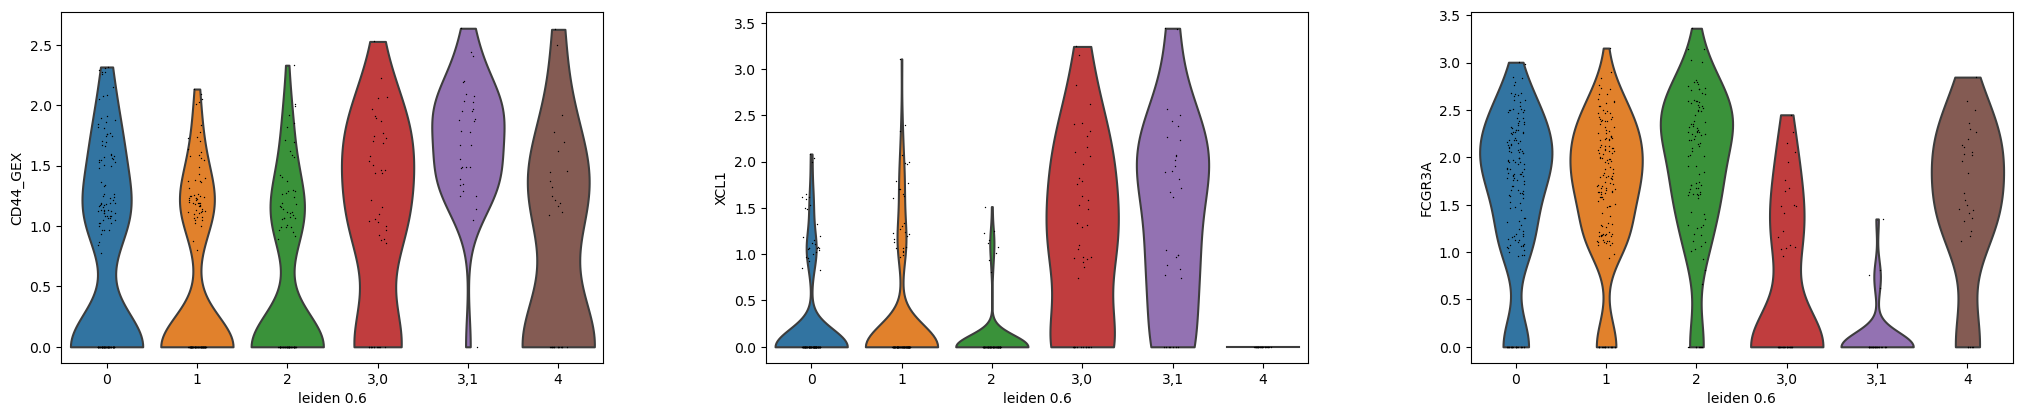

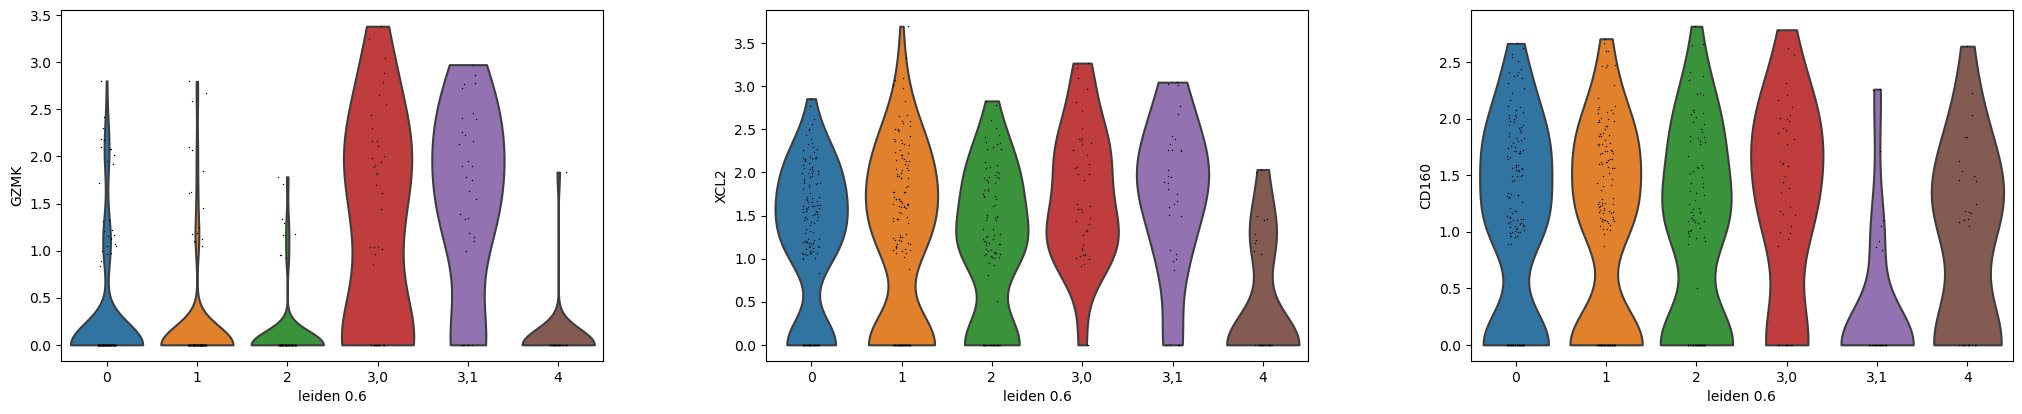

In [48]:
#Yang, CD56bright markers

sc.pl.violin(adata_latent, ['IL7R', 'SELL', 'KLRC1'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['CD44_GEX', 'XCL1', 'FCGR3A'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['GZMK', 'XCL2', 'CD160'], groupby='leiden_0.6')

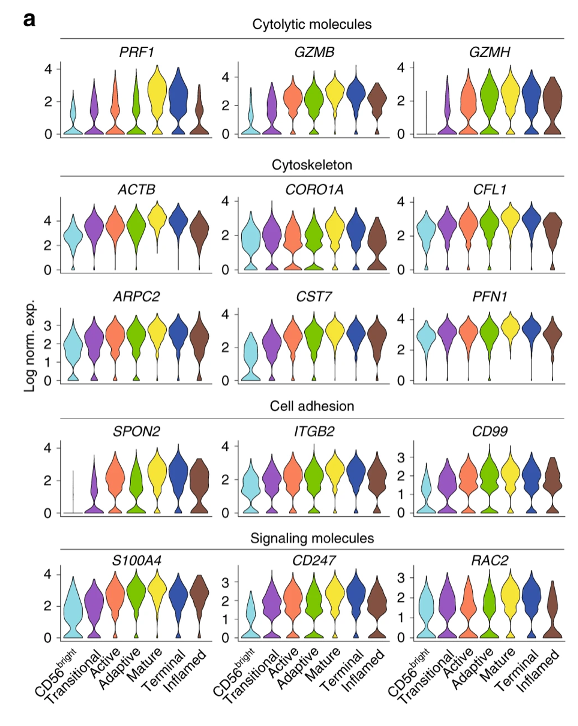

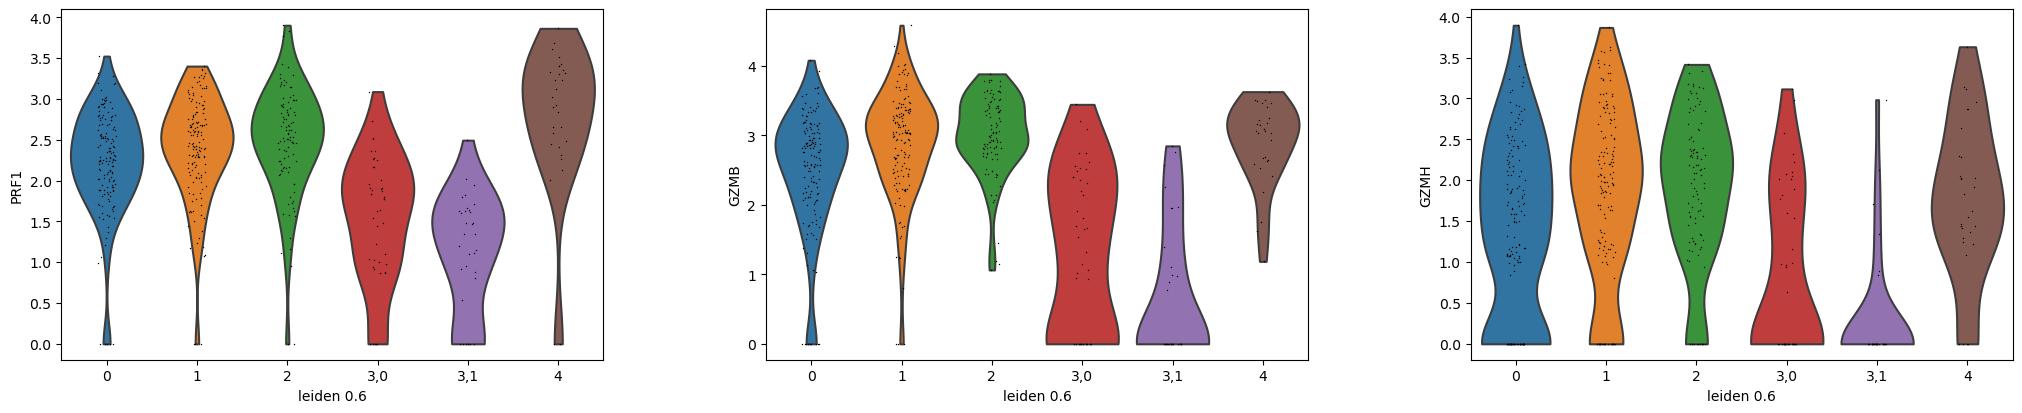

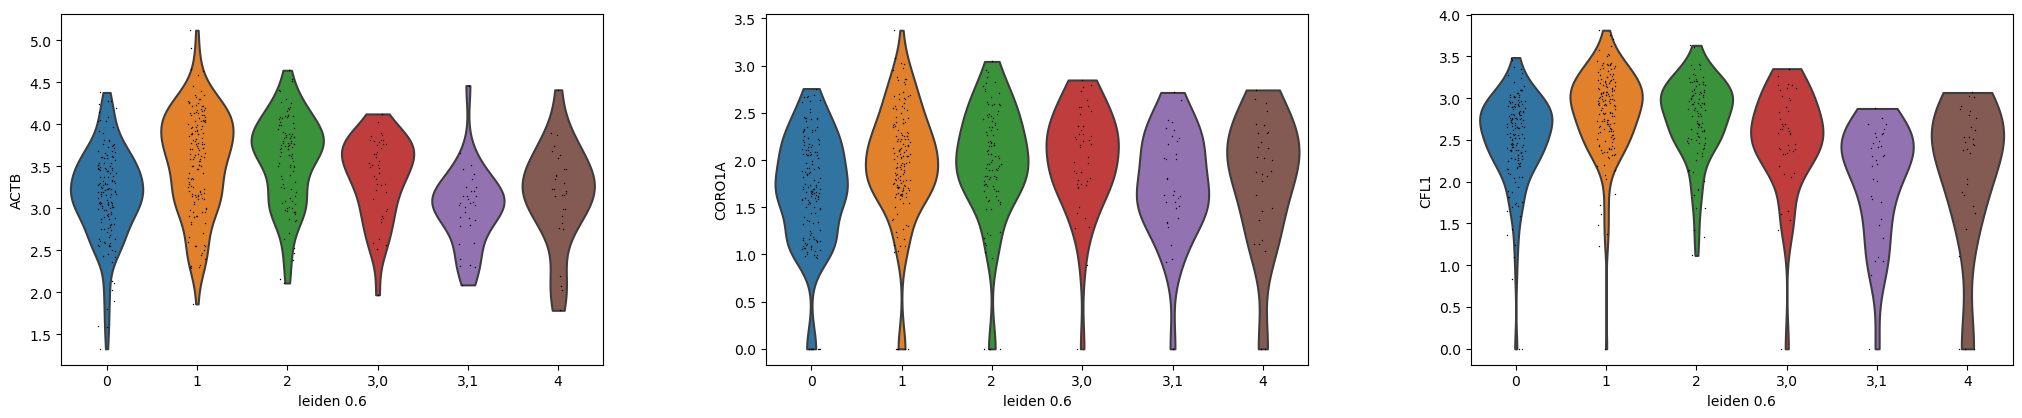

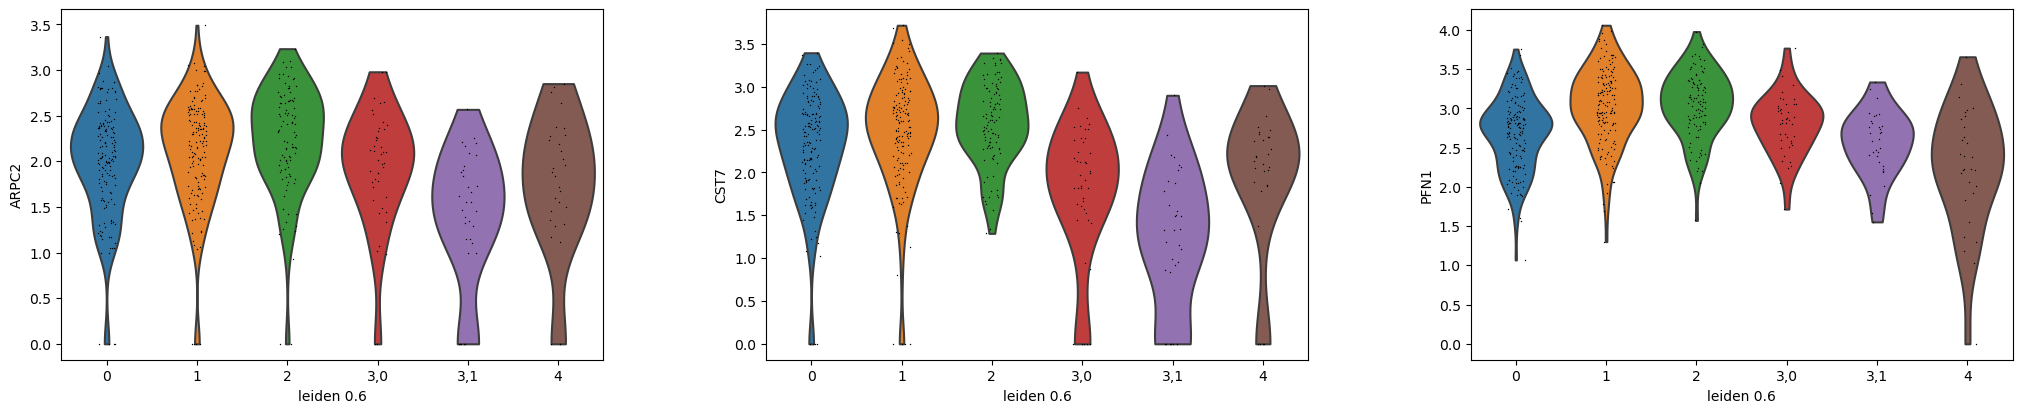

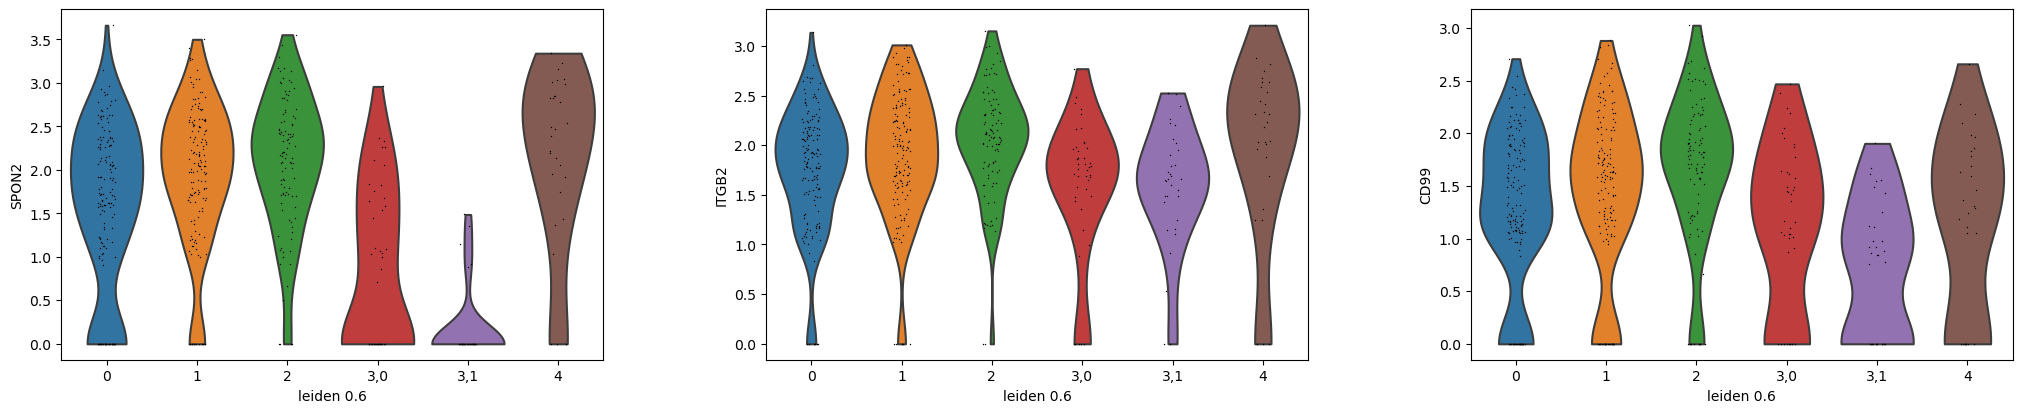

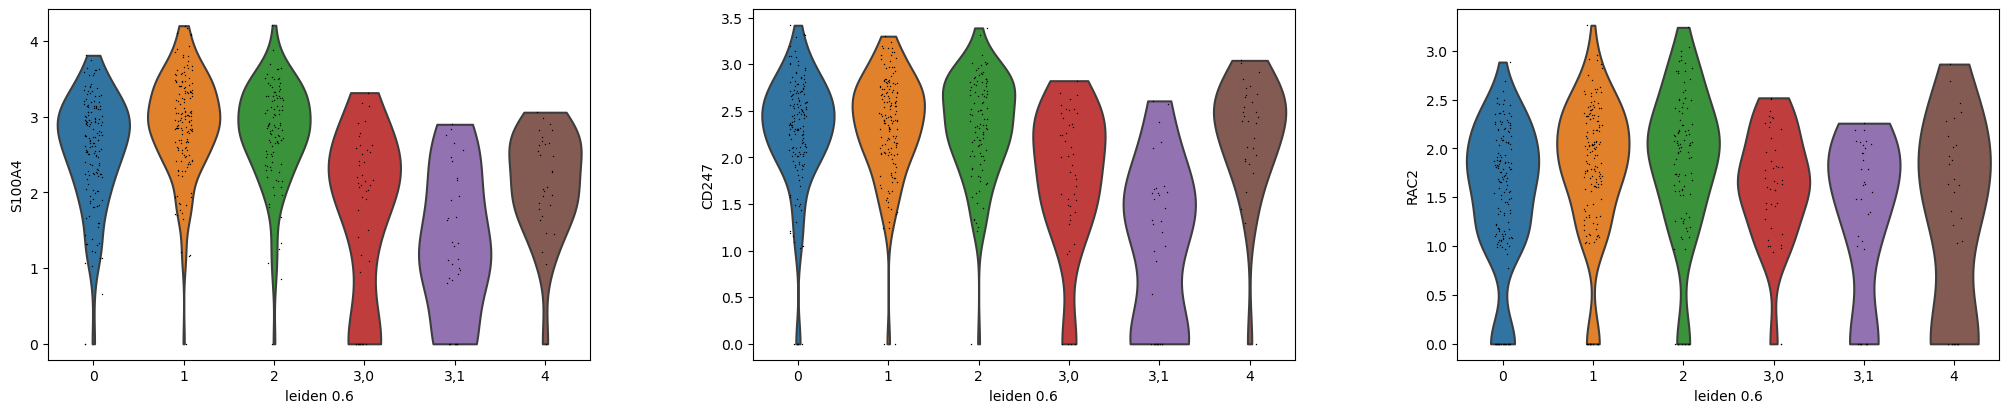

In [49]:
#Yang, functionally mature NKs

sc.pl.violin(adata_latent, ['PRF1', 'GZMB', 'GZMH'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['ACTB', 'CORO1A', 'CFL1'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['ARPC2', 'CST7', 'PFN1'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['SPON2', 'ITGB2', 'CD99'], groupby='leiden_0.6')
sc.pl.violin(adata_latent, ['S100A4', 'CD247', 'RAC2'], groupby='leiden_0.6')

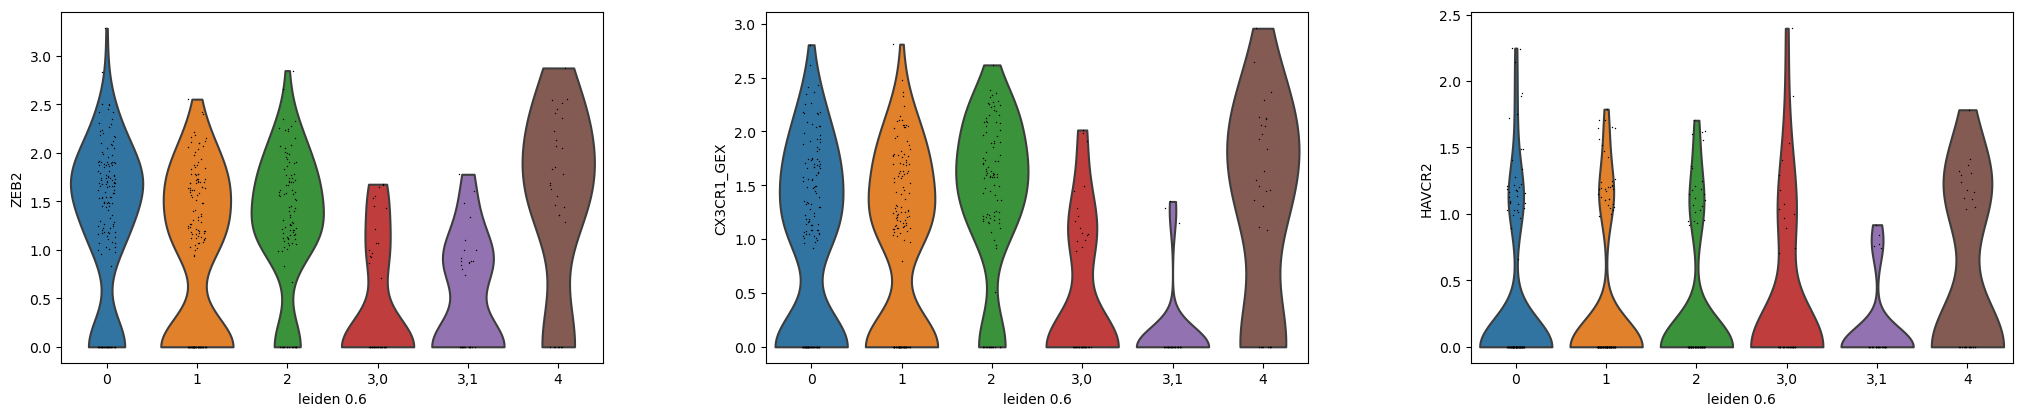

In [50]:
#Yang, terminally differentiated

sc.pl.violin(adata_latent, ['ZEB2', 'CX3CR1_GEX', 'HAVCR2'], groupby='leiden_0.6')


- Cluster 4 => terminally differentiated? 

# 2.2  Find marker genes/proteins from leiden clusters, protein

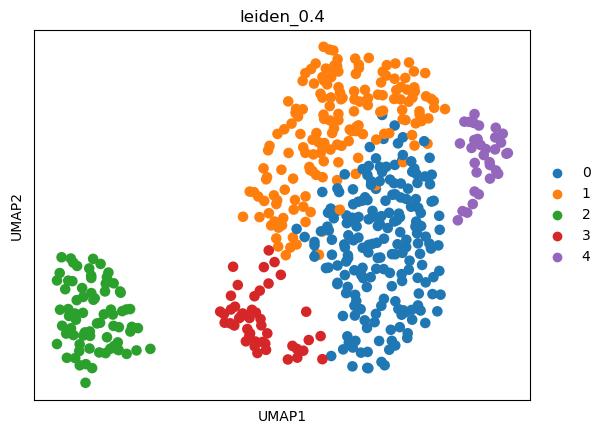

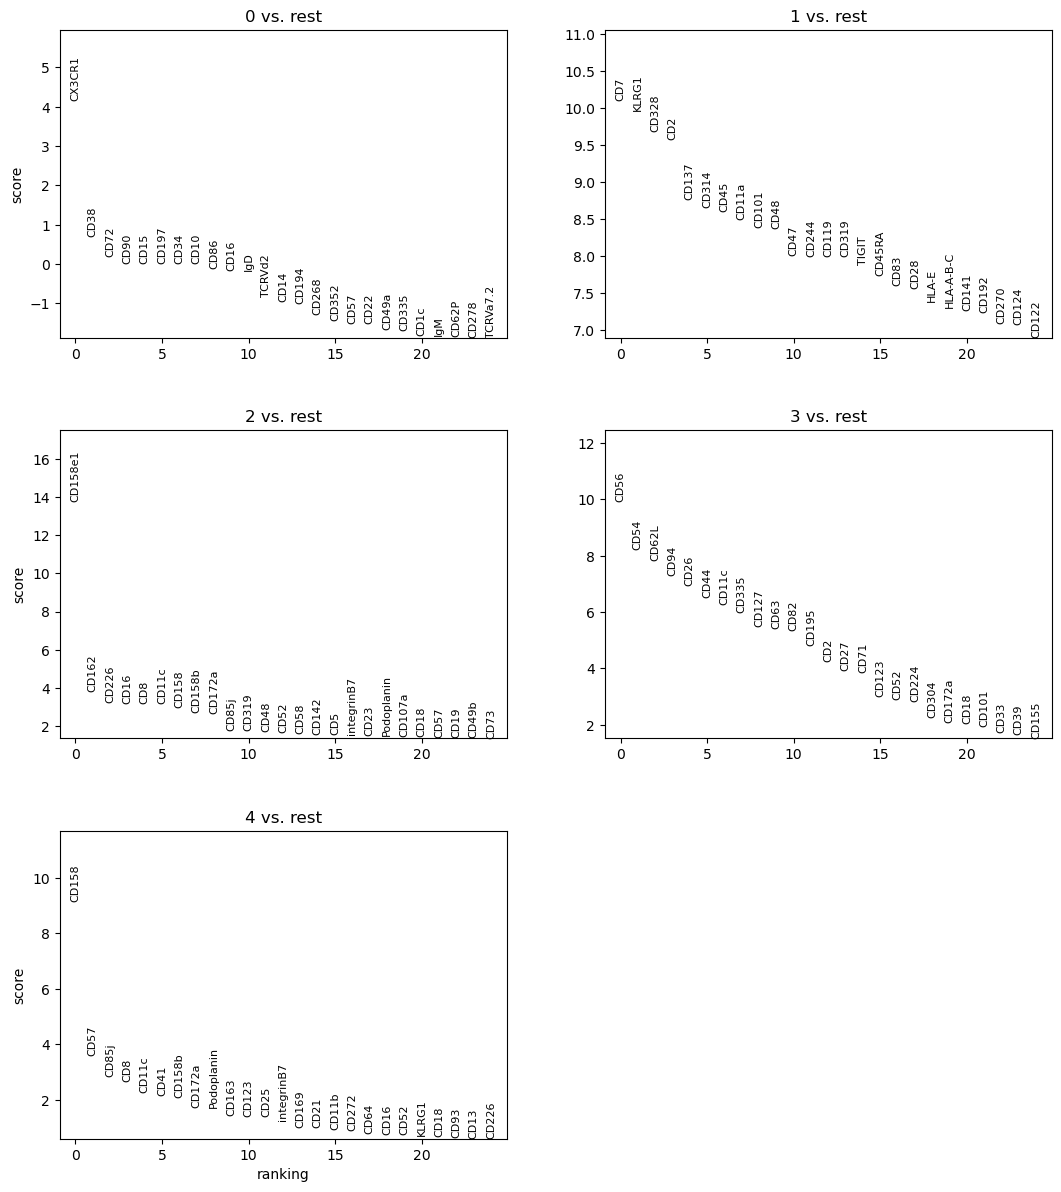

In [51]:
#Protein

sc.pl.umap(adata_adt, color=['leiden_0.4'])
sc.tl.rank_genes_groups(adata_adt, 'leiden_0.4', method='wilcoxon')
sc.pl.rank_genes_groups(adata_adt, n_genes=25, sharey=False, ncols=2)

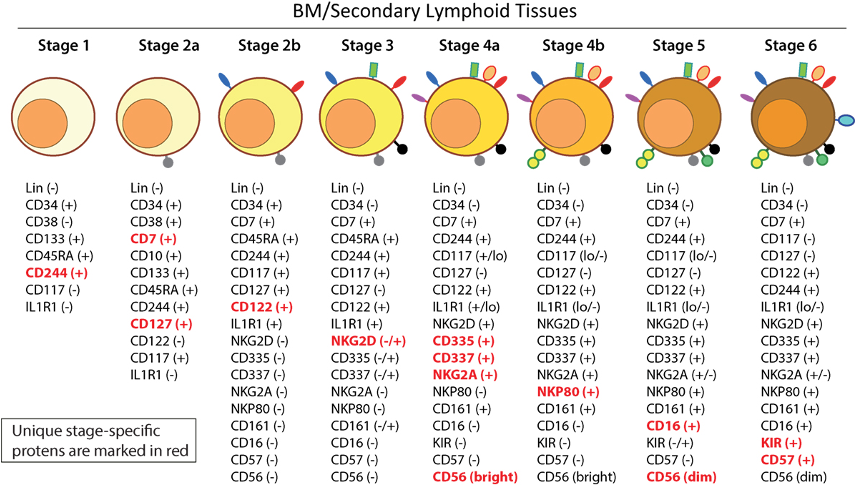

# 2.3  Find marker genes/proteins from leiden clusters, RNA

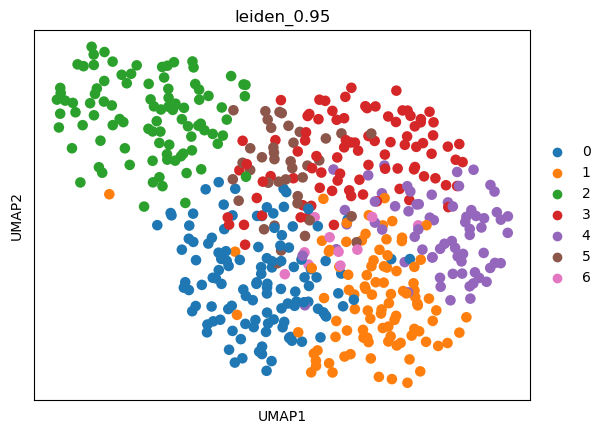

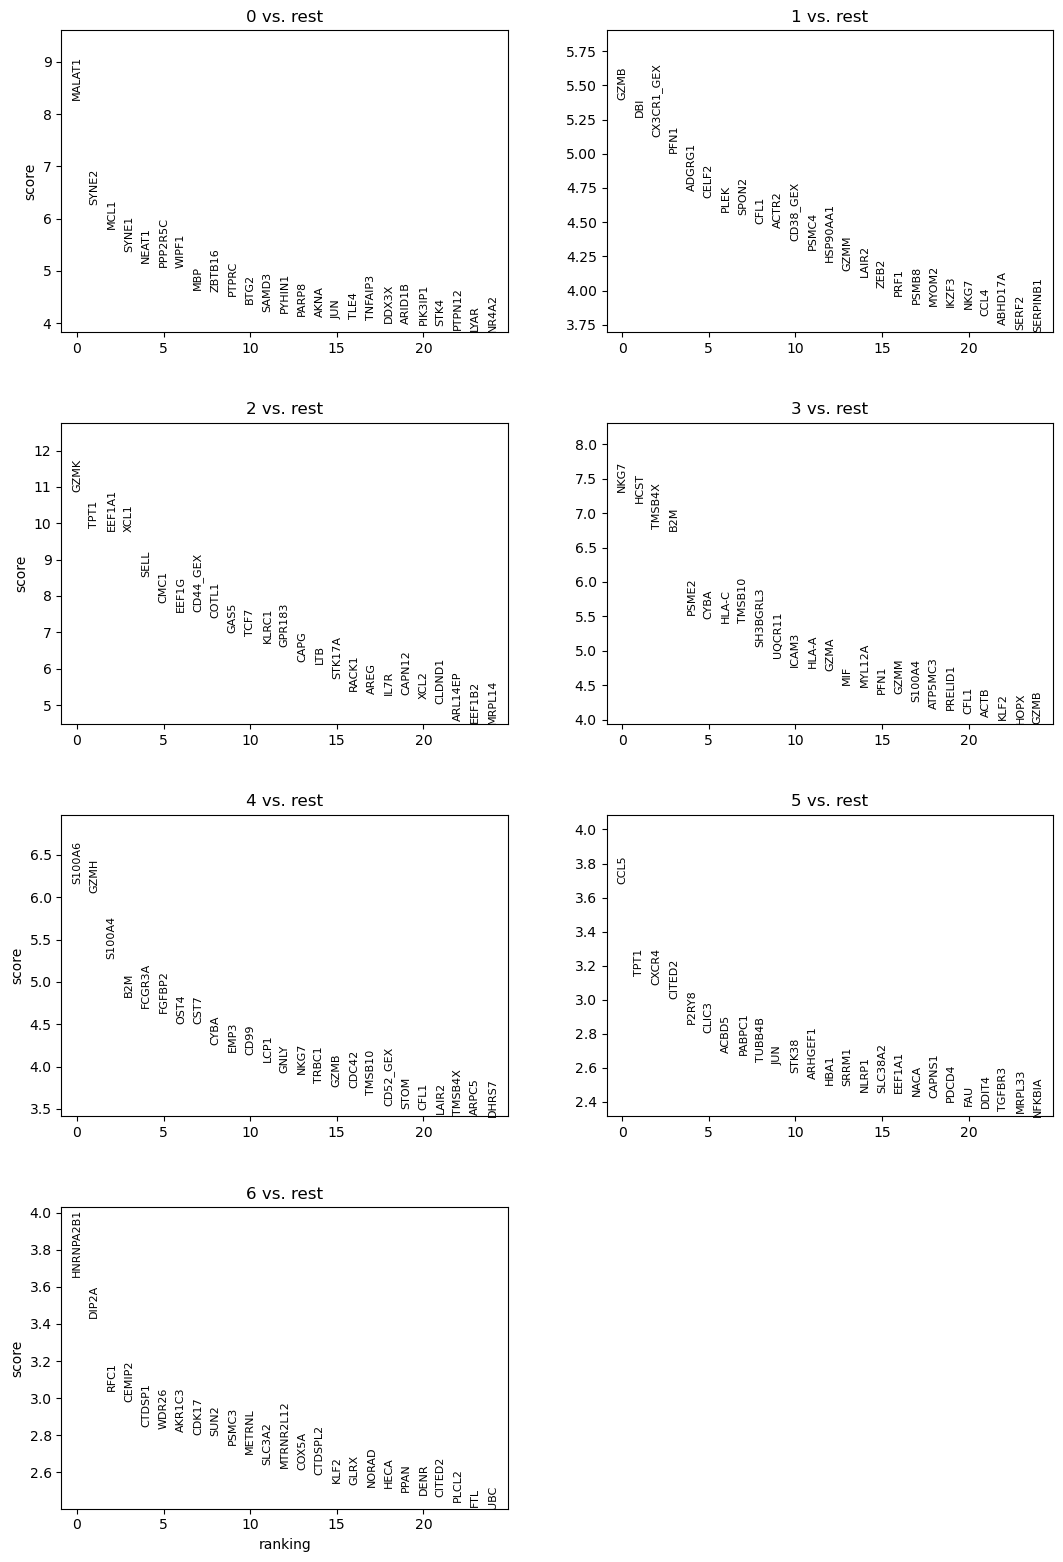

In [52]:
#RNA

sc.pl.umap(adata_gex, color=['leiden_0.95'])
sc.tl.rank_genes_groups(adata_gex, 'leiden_0.95', method='wilcoxon')
sc.pl.rank_genes_groups(adata_gex, n_genes=25, sharey=False, ncols=2)


- 